# Introduction

In this file, the simulation is conducted for an experiment akin to the one outlined in this [paper](http://cds.cern.ch/record/2712394/files/SPSC-P-364.pdf?version=1). The objective is to accurately reconstruct the trajectories of muons and antimuons both before and after exposure to the magnetic field, as well as their momentum and the center of mass energy for each pair. Before proceeding, several clarifications are necessary:

- The simulation is based on a dataset that was already generated.
- The reference system utilized follows the orientation specified in the paper, with the $z$-axis aligned with the direction of the positrons' momentum, the $y$-axis pointing towards the ceiling of the room, and the $x$-axis oriented accordingly.
- The magnetic field strength employed is 1.7 T over a length of 2 meters.


The overarching concept involves propagating the motion of positrons and subsequently muons and antimuons in the forward direction. Pixel detectors of yet-to-be-determined dimensions are positioned along their trajectories (results displayed below in the code). Following this, the objective is to simulate the particles' hits on the detectors, while also considering any Poissonian noise. The final aim is to reconstruct the trajectories for each pair of particles and to identify them without prior knowledge of the problem (in particular the charge of the particles and the noise-particle hit nature of the utilised data), enabling the determination of the momentum of each muon/antimuon. Subsequently, the estimated momentum can be compared with the actual momentum of the generated events to assess the accuracy of the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, MaxNLocator
import time
from tqdm import tqdm 
from itertools import product
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import pickle
import os
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

%matplotlib inline

In [2]:
# useful constants (S. I.)

c = 299792458 # m/s
e = 1.602176634e-19 # C 
muon_mass = 105.6583755e6*e / (c**2) # kg
electron_mass = 0.51099895000e6*e/(c**2) # kg


# experiment-related constant

B = 1.7 # T --> magnetic field
L = 2 # m --> length (along z) of the magnetic field region
z_mag = 8 # m --> z coordinate of the entrance of the magnetic field

## Loading data

In [3]:
raw_data = pd.read_csv("./data/dataset.txt",sep=" ",index_col=False)

# some positrons from the simulation have pz = 0 GeV --> They are excluded from the analysis
raw_data=raw_data[raw_data["pz_positron"]>0].reset_index(drop=True)
number_events = raw_data["x_scattering"].shape[0]
raw_data

,x_scattering,y_scattering,z_scattering,px_mu1,py_mu1,pz_mu1,px_mu2,py_mu2,pz_mu2,px_positron,py_positron,pz_positron
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918
...,...,...,...,...,...,...,...,...,...,...,...,...
999909,-0.002064,-0.006667,0.024110,0.013418,0.010555,26.1718,-0.013418,-0.010555,19.6198,0,0,45.7916
999910,-0.001824,-0.001494,0.026105,0.003372,0.019434,25.1396,-0.003372,-0.019434,20.5562,0,0,45.6958
999911,0.002128,-0.000650,0.028801,0.009716,0.008148,21.7877,-0.009716,-0.008148,22.5688,0,0,44.3564
999912,-0.000129,-0.003546,0.014003,-0.017934,0.020388,19.8603,0.017934,-0.020388,28.1794,0,0,48.0397


In [4]:
# here we rename all the columns to use an easier notation x y z
R_scattering = raw_data[['x_scattering', 'y_scattering', 'z_scattering']].rename(columns={'x_scattering': 'x', 'y_scattering': 'y', 'z_scattering': 'z'})
P_e = raw_data[['px_positron', 'py_positron', 'pz_positron']].rename(columns={'px_positron': 'x', 'py_positron': 'y', 'pz_positron': 'z'})
P_mu = raw_data[['px_mu1', 'py_mu1', 'pz_mu1']].rename(columns={'px_mu1': 'x', 'py_mu1': 'y', 'pz_mu1': 'z'})
P_anti_mu = raw_data[['px_mu2', 'py_mu2', 'pz_mu2']].rename(columns={'px_mu2': 'x', 'py_mu2': 'y', 'pz_mu2': 'z'})

## Particle propagation

The simulation generates two types of particles: positrons and muons (in pairs, negative and positive ones).

Positrons, originating from the beam, are assumed to travel perfectly along the $z$-axis. Hence, their motion can be simplified without considering equations of motion. For efficiency, it is assumed that a positron generated at a specific $(x,y)$ combination travels horizontally, altering only its $z$-coordinate. Upon hitting the detectors, positrons are located at positions $(x,y,z)$, where $x$ and $y$ are determined by the simulation, and $z$ represents the detector's position.

Muons, however, require more meticulous treatment. In order to propagate them in the forward direction, the Galilean relativity has been exploited. Their positions are calculated based on the assigned detector positions. For instance, if a detector is situated at $z$ = 5 m, the $(x,y)$ components of each muon are required when its $z$-coordinate is 5 m. To achieve this, the following formulas are employed:
$$\begin{cases}x(t) = x_0 + v_x \cdot t\\y(t) = y_0 + v_y \cdot t\\x(t) = z_0 + v_z \cdot t\end{cases}$$
where the velocities were calculated as:
$$\begin{cases}v_x = p_x/m_\mu\\v_y = p_y/m_\mu\\v_z = p_z/m_\mu\end{cases}$$

## Detector class
We developed a specialized class to manage hits, which takes particle positions as input and converts them to the center of the pixel they strike. This value represents what is recorded by the readout electronics. Once the events are loaded into this class, it can generate a Poissonian distribution of noise events for each trigger.

Within the detector object, both real hits and noise hits are stored separately for each trigger. Consequently, a function was implemented to return noise and physical hits indistinguishably for the i-th trigger. This reflects the behavior of the detector.

### Helper functions for this section

In [5]:
def get_velocity(p,m):
    # function that takes as input a dataframe containing the momentum and the mass of a particle
    # and using the laws of Galilean relativity (not relativistic velocities). 
    # It returns a dataframe with the velocities
    
    vx = p["x"]*1e9*e/(c*m)
    vy = p["y"]*1e9*e/(c*m)
    vz = p["z"]*1e9*e/(c*m)
    v=pd.DataFrame({"x":vx,"y":vy,"z":vz})

    return v

In [6]:
def propagate_particles(r_old, p, z_new, m):
    # this function, based on the initial position, momentum, mass and final 
    # position along z, propagates the muons up to the desired z
    
    # find proper time
    v=get_velocity(p,m)
    t=(z_new-r_old["z"])/v["z"]

    # compute new positions
    x_new = r_old["x"] + v["x"]*t
    y_new = r_old["y"] + v["y"]*t
    z_new = r_old["z"] + v["z"]*t
    
    r_new = pd.DataFrame({"x":x_new,"y":y_new,"z":z_new})
    return r_new

In [7]:
def get_edges(pixel_length, x_center, y_center, x_length, y_length, oversize_pixels = 20):
    # this function is a fuction that is used to make plots, it is not used for analysis. 
    # Since each detector is made up of pixels we want each bin to represent a pixel 
    # in the counts histograms. Furthermore, since it would otherwise be difficult to 
    # interpret, we also want the histogram to cover a region slightly larger than 
    # the detector itself, so as to have a better idea of the proportions. This function 
    # returns the edges of the bins that such a histogram must have. The "oversize_pixels" 
    # parameter indicates how many more pixels we need want to plot on the left, on right, 
    # above and below the edges of the detector itself.
   
    edges_x = np.arange(x_center-x_length/2 -oversize_pixels * pixel_length, x_center + x_length/2 + oversize_pixels * pixel_length ,pixel_length)
    edges_y = np.arange(y_center-y_length/2 -oversize_pixels * pixel_length, y_center + y_length/2 + oversize_pixels * pixel_length ,pixel_length)

    return [edges_x, edges_y]

In [8]:
class Detector:
    # this class is written to more easily manage the information collected by a detector. 
    # It allows the user to load data, generate noise, and at the same time it behaves as a detector 
    # would via the get_trigger function, which returns data and noise indistinctly. 
    # The convenience lies in being able to keep the various data and noise separate inside, so 
    # as to evaluate the behavior of the simulation, but also to be able to return 
    # them as completely indistinguishable, as in a real experiment.
     
    def __init__(self, x_center, y_center, z_center, x_length, y_length, pixel_length):
        self.x_center = x_center # detector center x
        self.y_center = y_center # detector center y
        self.z_center = z_center # detector center Z
        self.x_length = x_length # detector length along x
        self.y_length = y_length #detector length along y
        self.pixel_length = pixel_length # length of a single pixel
        self.dataset_dict = {} # dictionary containing all dataset loaded with a label as key

        # create an array with all pixel_centers
        self.npixels_x = int(x_length / pixel_length)
        self.npixels_y = int(y_length / pixel_length)
        x_range = np.linspace(x_center - x_length/2 + pixel_length/2, x_center + x_length/2 - pixel_length/2, self.npixels_x)
        y_range = np.linspace(y_center - y_length/2 + pixel_length/2, y_center + y_length/2 - pixel_length/2, self.npixels_y)
        x, y = np.meshgrid(x_range, y_range)
        self.pixel_centers = np.column_stack((x.flatten(), y.flatten(), self.z_center*np.ones(len(x_range)*len(y_range) )))

        # control values
        self.is_noise_generated = False
        self.n_events = 0   # number of loaded events

    def load_data(self,R_positions: pd.DataFrame, label = "none"):
        # this function loads a dataset inside the class
        
        #check if the provided label is already in use
        if label in self.dataset_dict.keys():
            print("ERROR: trying to add a dataset with a label already in used --> stop")

        if self.n_events == 0:
            # if this is the first dataset we load --> set n_events
            self.n_events = R_positions.shape[0]
        elif R_positions.shape[0]!=self.n_events:
            # if there is already a dataset loaded check that this new one has the same dimension of the previous one
            print("ERROR: trying to add a datased with a different number of events with respect to the previous one --> stop")
        
        hits_map = R_positions.copy()
        # center on (0,0) so we can get properly the pixel with respect to the detector center
        hits_map["x"] = hits_map["x"] - self.x_center 
        hits_map["y"] = hits_map["y"] - self.y_center

        # approximate each event with the center of the pixel it hit
        hits_map["x"] = np.trunc(hits_map["x"] / pixel_length ) * pixel_length + np.sign(hits_map["x"]) * pixel_length / 2
        hits_map["y"] = np.trunc(hits_map["y"] / pixel_length ) * pixel_length + np.sign(hits_map["y"]) * pixel_length / 2

        # put everything back in the correct place 
        hits_map["x"] = hits_map["x"] + self.x_center
        hits_map["y"] = hits_map["y"] + self.y_center        
        self.dataset_dict[label]=hits_map
        
    def get_positions(self,label = "none"):
        # this function returns the dataframe that contains the hits of one of the loaded datasets according to the provided label
        
        if label not in self.dataset_dict.keys():
            print("ERROR: trying to get the positions of a dataset with label {}, but it is not there --> stop".format(label))
        
        return self.dataset_dict[label]

    def generate_poisson_noise(self,lambda_param):
        # this function generates the Poisson noise for each event
        
        if self.n_events == 0:
            print("ERROR: trying to create noise but no dataset loaded -->stop")
        self.is_noise_generated = True
        
        n_noise_per_trigger = np.random.poisson(lambda_param, size=self.n_events)    
        random_indices = np.random.choice(self.pixel_centers.shape[0], size=np.sum(n_noise_per_trigger))
        
        self.noise_list = np.split(self.pixel_centers[random_indices], np.cumsum(n_noise_per_trigger)[:-1])

    def get_noise_events(self, trigger_number):
        # this function returns the noise hits for a specific trigger number
        
        if not self.is_noise_generated:
            print("ERROR: trying to get a noise event, but noise is not generated yet! --> stop")
        list_events = self.noise_list[trigger_number]
        if len(list_events) != 0:
            #list_events = np.vstack(list_events)
            return np.unique(list_events, axis=0)
        return np.array(list_events)
    
    def get_real_events(self, trigger_number, label = "all"):
        # this function returns only real hits for a specific trigger number
        
        # check if we need the event only from a specific dataset
        if label != "all":
            return self.dataset_dict[label].loc[trigger_number].values

        # if we need all events then gather all events of the requested trigger
        list_events = [data.loc[trigger_number].values for data in self.dataset_dict.values()]
        list_events = np.vstack(list_events)
        
        # then, since one pixel can switch on just once every trigger, make sure that there are no repetitions.
        # At a physical level, a "repetition" in this case means that the same pixel was simultaneously 
        # hit by two particles, but since they can fire only once per trigger, each pixel has to be returned 
        # at most one time in this function
        unique_pixels = np.unique(list_events, axis=0)
        return unique_pixels

    def get_trigger(self, trigger_number):
        
        real_list = self.get_real_events(trigger_number)
        noise_list = self.get_noise_events(trigger_number)
        
        # ensure that each pixel in a single trigger is reported only once. 
        # On a physical level, a "repetition" in this case means that the same pixel was simultaneously 
        # both hit by a particle and affected by noise. However, this is impossible to notice at the 
        # output level given that with a trigger a pixel lights up only once.
        all_events = np.vstack([real_list,noise_list])
        unique_events = np.unique(all_events, axis=0)
        return unique_events


In [9]:
def choose_detector_specs(r, tolerance, pixel_length, verbose = True):
    # this function is used to choose the specs of a detector: position, x and y length
    # taking into account 100% acceptance of the simulation, and with a tolerance 
    # that can be tuned, and also according to the pixel length
    
    # find max, min and center
    x_min, x_max = r["x"].min()*tolerance, r["x"].max()*tolerance
    y_min, y_max = r["y"].min()*tolerance, r["y"].max()*tolerance
    x_center = round((x_max + x_min )/2, 4) # we assume a precision of 0.0001 m on the position of the detector
    y_center = round((y_max + y_min )/2, 4) # we assume a precision of 0.0001 m on the position of the detector

    # find the proper detector dimension taking into account the size of each single pixel
    # in this way the function ensures that the detector is defined with an integer 
    # number of pixels, and that each time there are the same number of pixels on the 
    # right and on left of the center, and the same number above and below the center.
    half_x = (x_max-x_min)*tolerance / 2
    half_x = int(half_x / pixel_length) * pixel_length # now this value is a multiple of pixel_length
    length_detector_x = 2*half_x
    n_pixels_x = length_detector_x/pixel_length

    half_y = (y_max-y_min)*tolerance / 2
    half_y = int(half_y / pixel_length) * pixel_length
    length_detector_y = 2*half_y
    n_pixels_y = length_detector_y/pixel_length

    # brief summary
    if verbose:
        print("\nfor detector at z={} m we choose:\n".format(round(r["z"][0], 3)),
              "- length".format(r["z"][0]), "of {} m along x and {} m along y\n".format(round(length_detector_x,6), round(length_detector_y,6)),
              "- center in ({}, {}) m \n".format(x_center,y_center),
              "- with square pixels of size {}x{} μm the detector is a matrix of {}x{} pixels".format(pixel_length*1e6,pixel_length*1e6, round(n_pixels_x), round(n_pixels_y)))
        
    return x_center, y_center, r["z"][0], length_detector_x, length_detector_y, pixel_length

In [10]:
def place_detector_on_hitsmap(ax, x_center, y_center, length_detector_x, length_detector_y):
    # function used to draw the edges of a detector over a pyplot axes
    
    x_min = x_center - length_detector_x/2
    y_min = y_center - length_detector_y/2
    square = Rectangle((x_min, y_min), length_detector_x, length_detector_y, linewidth=1.5, edgecolor='red', facecolor='none',label="detector")
    _ = ax.add_patch(square)
    ax.legend(loc='upper right')
 
    return

## Analysis for positrons

### Code

In [11]:
z_positron_detectors = np.array([-0.30, -0.15, -0.10]) # z of the silicon trackers before berillium target (we're traking positrons here)

r_upstream_positions = {} # positions of detectors according to the simulation
positron_detectors= {} # positron detectors
for z_new in z_positron_detectors:
    r_upstream_positions[z_new]=R_scattering.copy()
    r_upstream_positions[z_new]["z"]=np.ones(number_events)*z_new

Assuming square pixels of size 200.0x200.0 μm and a tolerance of 1.05 %

for detector at z=-0.3 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels

for detector at z=-0.15 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels

for detector at z=-0.1 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels


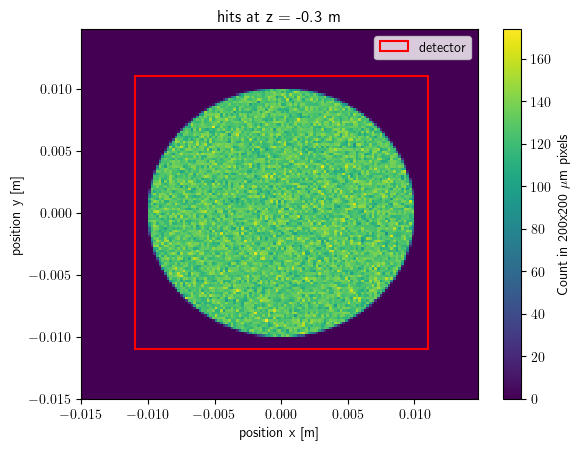

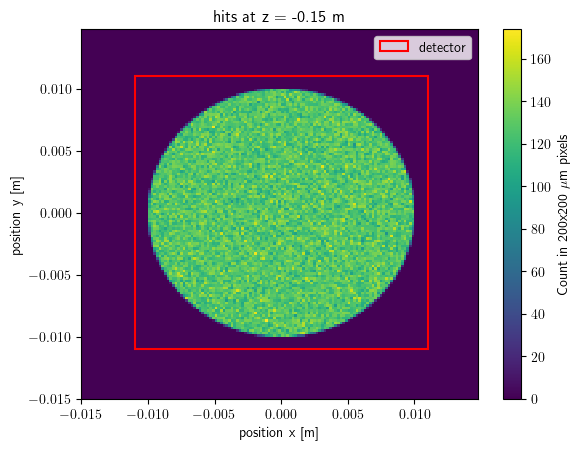

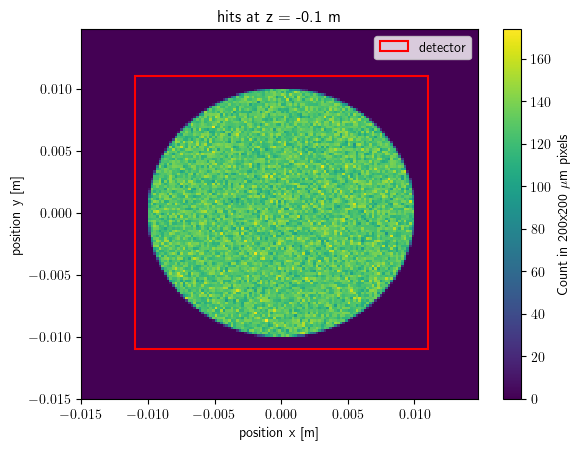

In [12]:
pixel_length = 200e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %".format(pixel_length*1e6, pixel_length*1e6, tolerance))
for z_pos, data in  r_upstream_positions.items():
    # create hits map 
    x_center, y_center, z_center, x_length, y_length, pixel_length = choose_detector_specs(data, tolerance, pixel_length)
    detector = Detector(x_center, y_center, z_center, x_length, y_length, pixel_length)
    detector.load_data(data)
    positron_detectors[z_pos]=detector

    # plot hits_map
    # here I draw the histogram already using the hit data as if it were a detector, I don't use the simulation directly
    df_positions = detector.get_positions()
    fig, ax = plt.subplots(1,1)
    hist = ax.hist2d(df_positions["x"],df_positions["y"],bins=get_edges(pixel_length, x_center, y_center, x_length, y_length), cmap = "viridis")
    cbar = fig.colorbar(hist[3], ax=ax, cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    cbar.set_label(r'Count in {}x{} $\mu$m pixels'.format(pixel_length_label, pixel_length_label))
    ax.set_xlabel("position x [m]")
    ax.set_ylabel("position y [m]")
    ax.set_title("hits at z = {} m".format(data["z"][0]))
    place_detector_on_hitsmap(ax, x_center, y_center, x_length, y_length)

## Analysis for muons before magnetic field

### Code

In [13]:
z_downstream_muons_detectors = np.array([3, 5, 7 ]) # z position of muons detectors before magnetic field

r_downstream__muons_positions = {} # positions of muons according to the simulation
upstream_muons_detectors = {} # detectors for muons
for z_new in z_downstream_muons_detectors:
    R_mu_tmp = propagate_particles(R_scattering,P_mu,z_new,muon_mass)
    R_anti_mu_tmp = propagate_particles(R_scattering,P_anti_mu,z_new,muon_mass)
    data_tmp = {"n": R_mu_tmp.copy(), "p": R_anti_mu_tmp.copy()}
    r_downstream__muons_positions[z_new]=data_tmp

Assuming square pixels of size 50.0x50.0 μm and a tolerance of 1.05 %:

for detector at z=3.0 m we choose:
 - length of 0.0325 m along x and 0.0327 m along y
 - center in (0.0, -0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 650x654 pixels
 ATTENTION: in this case only 0.0022% of the pairs are at a distance smaller than the pixel size

for detector at z=5.0 m we choose:
 - length of 0.0396 m along x and 0.0401 m along y
 - center in (0.0001, -0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 792x802 pixels
 ATTENTION: in this case only 0.0013% of the pairs are at a distance smaller than the pixel size

for detector at z=7.0 m we choose:
 - length of 0.0468 m along x and 0.0476 m along y
 - center in (0.0001, 0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 936x952 pixels
 ATTENTION: in this case only 0.0009% of the pairs are at a distance smaller than the pixel size


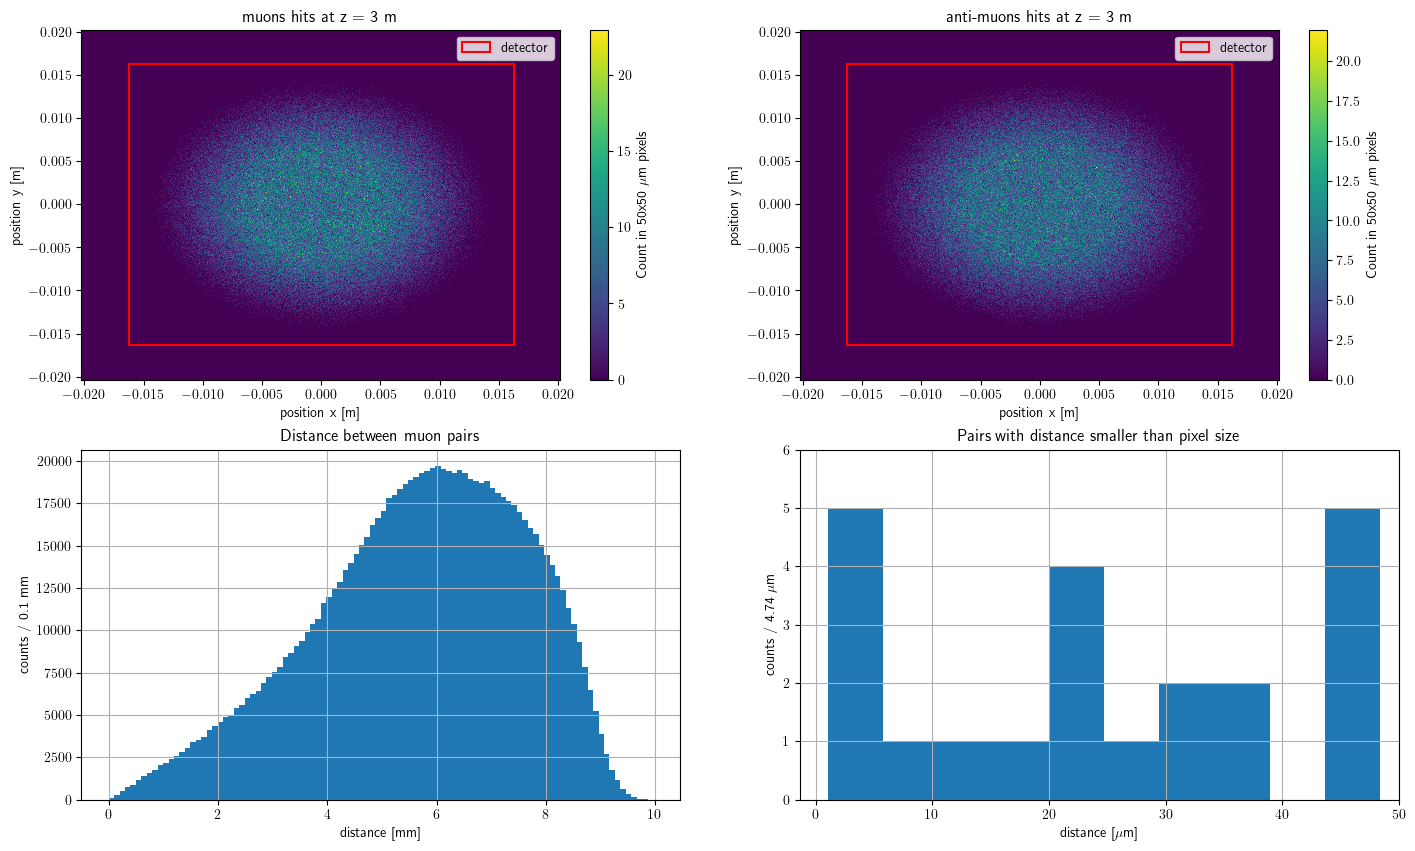

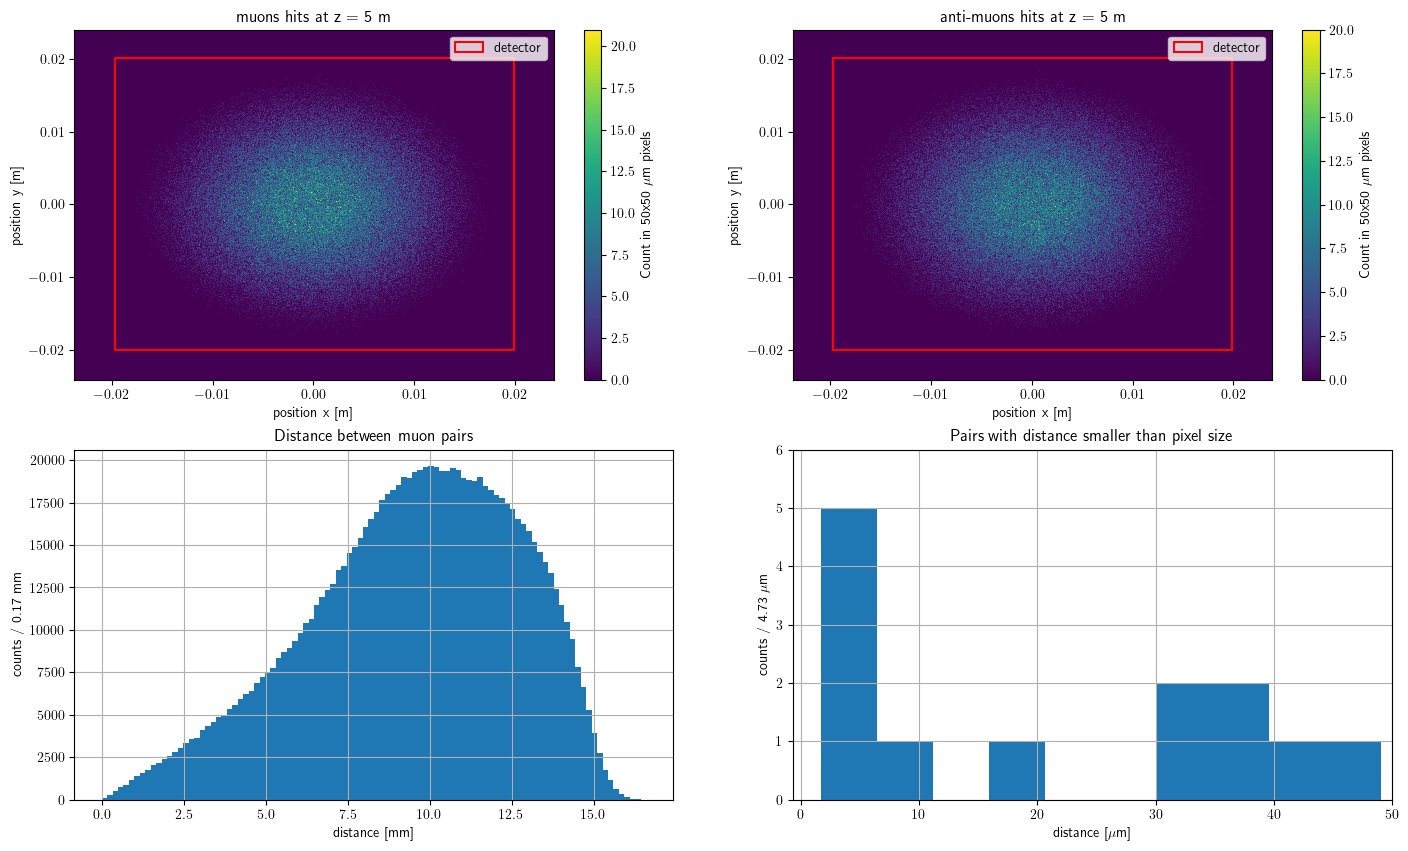

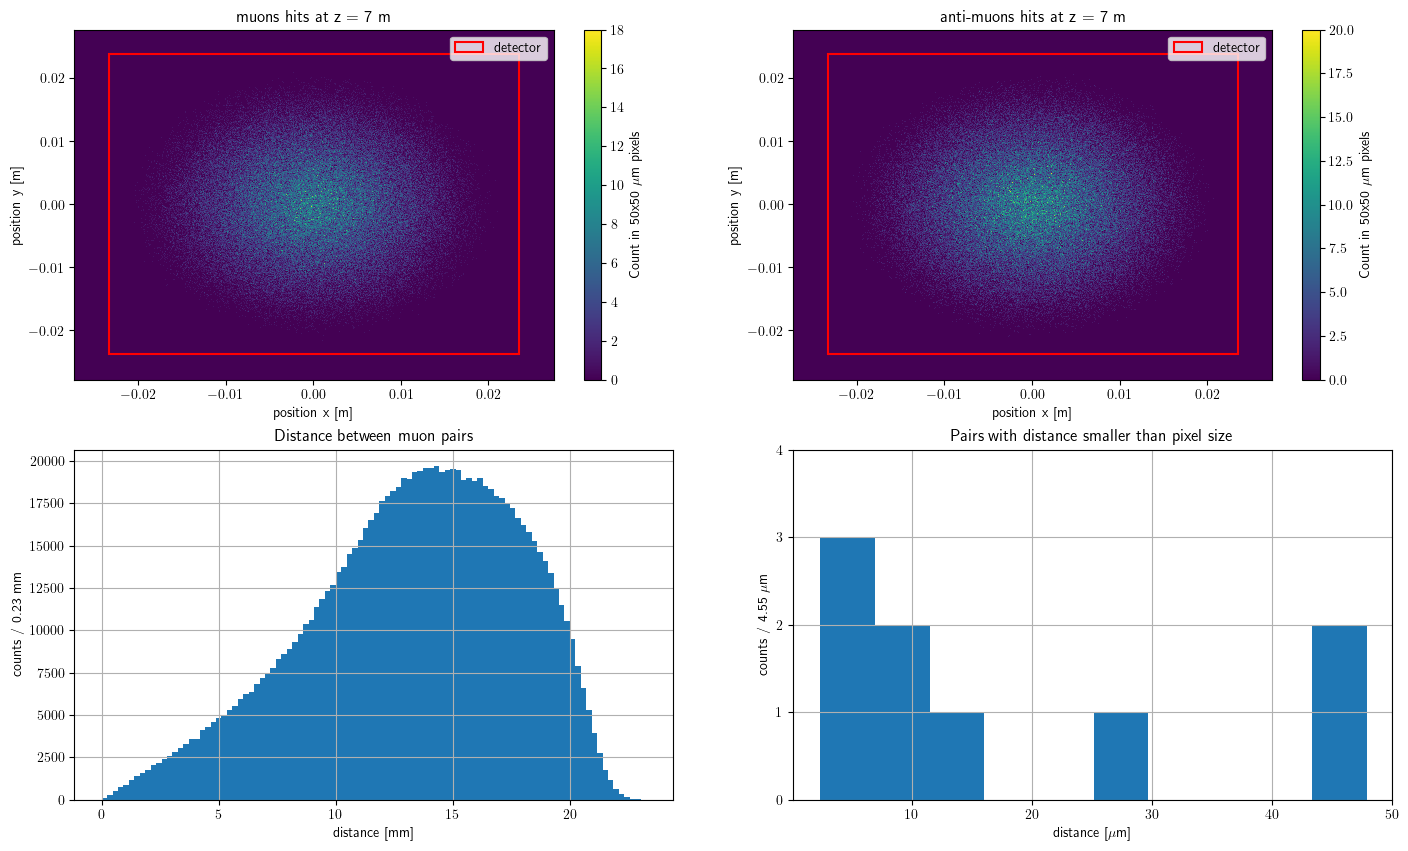

In [14]:
pixel_length = 50e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %:".format(pixel_length*1e6,pixel_length*1e6, tolerance))

for z_new, data_dic in  r_downstream__muons_positions.items():
    # create hits map
    total_dataset = pd.concat(data_dic.values(),ignore_index=True)
    x_center, y_center, z_center, x_length, y_length, pixel_length = choose_detector_specs(total_dataset,tolerance,pixel_length)
    edges = get_edges(pixel_length, x_center, y_center, x_length, y_length, 80)

    detector_tmp = Detector(x_center, y_center, z_center, x_length, y_length, pixel_length)
    detector_tmp.load_data(data_dic["p"],"p")
    detector_tmp.load_data(data_dic["n"],"n")

    upstream_muons_detectors[z_new]=detector_tmp

    # plot hits maps
    df_positions_p = detector_tmp.get_positions("p")
    df_positions_n = detector_tmp.get_positions("n")
    fig, ax = plt.subplots(2,2, figsize = (17,10) )
    hist_muons_p = ax[0,0].hist2d(df_positions_p["x"],df_positions_p["y"],bins=edges, cmap = "viridis")
    hist_muons_n = ax[0,1].hist2d(df_positions_n["x"],df_positions_n["y"],bins=edges, cmap = "viridis")
 
    histograms_2d = [hist_muons_n, hist_muons_p]
    labels = ["muons", "anti-muons"]

    for a, hist, label in zip(ax[0],histograms_2d, labels):
        cbar = fig.colorbar(hist[3], ax=a, cmap="viridis")
        pixel_length_label = round(pixel_length*1e6)
        cbar.set_label(r'Count in {}x{} $\mu$m pixels'.format(pixel_length_label,pixel_length_label))
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(label, z_new))
        place_detector_on_hitsmap(a, x_center, y_center, x_length, y_length)

    
    # plot 1d histogram with separation between pairs distribution
    df_dist = (data_dic["p"]-data_dic["n"]) # distance between pairs
    abs_dist = np.sqrt(df_dist["x"]**2 + df_dist["y"]**2 ) # distance in m
    abs_dist_small = abs_dist[abs_dist < pixel_length]     # select events with distance between muons < pixel_length

    abs_dist=abs_dist*1e3                # conversion from m --> mm to make the graph easier to read
    abs_dist_small=abs_dist_small*1e6    # conversion from m --> μm to make the graph easier to read
    
    hist_dist = ax[1,0].hist(abs_dist,bins=100)
    hist_dist_lost = ax[1,1].hist(abs_dist_small,bins=10)
    ax[1,1].set_xlim(right = pixel_length*1e6)
    ax[1,1].set_yticks(range( int(hist_dist_lost[0].max())+2))

    ax[1,0].set_xlabel("distance [mm]")
    ax[1,1].set_xlabel(r"distance [$\mu$m]")
    
    ax[1,0].grid(True)
    ax[1,1].grid(True)

    ax[1,0].set_ylabel("counts / {} mm".format(round(hist_dist[1][1]-hist_dist[1][0],2)))
    ax[1,1].set_ylabel(r"counts / {} $\mu$m".format(round(hist_dist_lost[1][1]-hist_dist_lost[1][0],2)))

    ax[1,0].set_title("Distance between muon pairs")
    ax[1,1].set_title("Pairs with distance smaller than pixel size")

    fraction_pair_lost = round(np.sum(hist_dist_lost[0])*100/np.sum(hist_dist[0]),6)
    print(" ATTENTION: in this case only {}% of the pairs are at a distance smaller than the pixel size".format(fraction_pair_lost))    
    

## Propagation of the muons and antimuons in the magnetic field

#### At the entrance of the magnetic field
In order to get the position of the muons and antimuons in the $xy$ plane at the entrance of the magnetic field region, they need to be propagated in the forward direction. Considering $z_\mathrm{mag}=8$ m as the $z$ coordinate of the entrance of the magnetic field region, for each particle, the time elapsed between the scattering (occurring in $(x_\mathrm{scat}, y_\mathrm{scat}, z_\mathrm{scat})$) and the instant in which it reaches the entrance of the magnetic field can be computed as:
$$\tilde{t}=\frac{z_\mathrm{ent}-z_\mathrm{scat}}{p_{z\mu}},$$
where the time $\tilde{t}$ is expressed as a time over the muon mass ($t/m_\mu$) in order to simplify the calculations in the code since we are interested in the position and not the time itself.
<br>
For each particle the $x$ and $y$ coordinates at the entrance of the magnetic field region are given by:
$$x_\mathrm{in}=x_\mathrm{scat}+p_{x\mu}\cdot \tilde{t},$$
$$y_\mathrm{in}=y_\mathrm{scat}+p_{y\mu}\cdot \tilde{t}.$$
#### In the magnetic field
When the muons and the antimuons enter the region in which the magnetic field $\overrightarrow{B}$ is present, they experience the Lorentz force
$$\overrightarrow{F}_\mathrm{L}=q\overrightarrow{v_{zx}}\times \vec{B},$$
where $q$ is the charge of the muon or antimuon
and, preserving the component of the momentum parallel to the magnetic field, they move along an arc of circumference perpendicular to the direction of the magnetic field, on $xz$-plane, as it is shown in the figure.
<br>
The radius of the circumference is given by:
$$R=\frac{m|\overrightarrow{v_{zx}}|}{q|\overrightarrow{B}|},$$
where $m$ is the mass of the particle and $|\overrightarrow{v_{zx}}|=\sqrt{v_x^2+v_z^2}$.
<br>
Knowing the radius of the arc of circumference described by each particle, it is possible to estimate the coordinates of the center of the circumference in the $zx$ plane, $(z_\mathrm{C}, x_\mathrm{C})$. According to the charge of the particle there are two cases:
* for muons:
$$z_\mathrm{C}=z_\mathrm{in}-R\cos\beta;$$
$$x_\mathrm{C}=x_\mathrm{in}+R\sin\beta;$$

* for antimuons:
$$z_\mathrm{C}=z_\mathrm{in}+R\cos\beta;$$
$$x_\mathrm{C}=x_\mathrm{in}-R\sin\beta.$$

With this information it is then possible to estimate the $x$ coordinate of the exit point from the magnetic field region, $x_\mathrm{out}$ as
$$x_\mathrm{out}=\pm\sqrt{R^2-(z_\mathrm{out}-z_\mathrm{C})^2}+x_\mathrm{C},$$
where the sign in front of the square root depends on the particle's charge.

This allows to estimate the length of the chord 
$$len(\overline{EE^{'}})=\sqrt{(z_\mathrm{out}-z_\mathrm{in})^2+(x_\mathrm{out}-x_\mathrm{in})^2},$$
and so, exploiting the theorem of the chord, it is possible to estimate the rotation angle $\theta$:
$$
len(\overline{EE^{'}})=2R\sin\Bigg(\frac{\theta}{2}\Bigg)
\qquad
\Rightarrow
\qquad
\theta=2\arcsin\Bigg(\frac{len(\overline{EE^{'}})}{2R}\Bigg).$$
Considering the length of the arc of circumference which is described by each particle, $len(arc)=R\theta$, the $y$ exit coordinate from the magnetic field region is obtained as:
$$ y_\mathrm{out}=y_\mathrm{in}+len(arc)\cdot\frac{p_y}{p_{zx}}$$


The rotation angle in this way is considered always positive and the particles' momentum components along the $x$ and $z$ axes are rotated taking into account their charge: the rotation of the $(p_z, p_x)^\mathrm{t}$ vector is anticlockwise for muons and clockwise for antimuons.

<center>
    <img src="./pictures/B_track.PNG" alt="B_track" width="600"/>  
</center>



In the Python code the propagation for muons and antimuons are put together in a unique function.

### Helper functions for this subsection


In [15]:
def propagate_particles_in_Bfield(R_entrance, p_entrance, charge_sign, z_exit, m, B, L):
    # this function propagates the particles in the magnetic field taking as input the entrance coordinates,
    # the entrance momentum, the z exit coordinate, the muon mass and the magnetic field.
    # It returns a dataframe containing the exit coordinates from the magnetic field 
    # and a dataframe containing the momentum components at the exit of the magnetic field region.

    # modulus of the velocity component on the xz plane
    p_perp = np.sqrt(p_entrance["x"]**2 + p_entrance["z"]**2)
    # radius of the arc of circumference described by the particle
    R = np.sqrt(p_entrance["x"]**2 + p_entrance["z"]**2)*1e9/(c*B)

    # coordinates for the centre of the circumference
    # the different sign is due to the different curvature for muons and antimuons in the magnetic field due to their charge
    # and for the sign of the component of the momentum along the x axis for the case of the z coordinate
    m = p_entrance["x"]/p_entrance["z"]
    z_tmp = np.sign(m*charge_sign)*R/np.sqrt(1+m**-2)
    x_tmp = -z_tmp/m

    # coordinates of the center of the circumference
    z_centre = R_entrance["z"] + z_tmp
    x_centre = R_entrance["x"] + x_tmp

    # new z and x coordinates after the propagation in the magnetic field
    z_new = R_entrance["z"]+L
    x_new = x_centre + np.sign(charge_sign) * np.sqrt(R**2 - (z_new-z_centre)**2)

    # rotation angle and new y coordinate at the exit of the magnetic field
    chord = np.sqrt( (R_entrance["z"]-z_new)**2 + (R_entrance["x"]-x_new)**2 )
    theta = 2*np.arcsin(chord/(2*R))
    arc = R*theta
    y_new = R_entrance["y"] + arc*p_entrance["y"]/p_perp

    # DataFrame containing the three components of the exit point 
    r_new = pd.DataFrame({"x": x_new, "y": y_new, "z": z_new})

    px_new = -np.sign(charge_sign)*p_entrance["z"]*np.sin(theta)+p_entrance["x"]*np.cos(theta)
    py_new = p_entrance["y"]
    pz_new = p_entrance["z"]*np.cos(theta)+np.sign(charge_sign)*p_entrance["x"]*np.sin(theta)

    # DataFrame containing the three components of the exit momentum
    p_new = pd.DataFrame({"x": px_new, "y": py_new, "z": pz_new})
    
    
    return r_new, p_new

### Code

In [16]:
# propagation of the particles until the beginning of the magnetic field
# coordinates at the entrance position in the magnetic field
R_mu_entrance = propagate_particles(R_scattering, P_mu, z_mag, muon_mass)
R_anti_mu_entrance = propagate_particles(R_scattering, P_anti_mu, z_mag, muon_mass)

#### Quick check

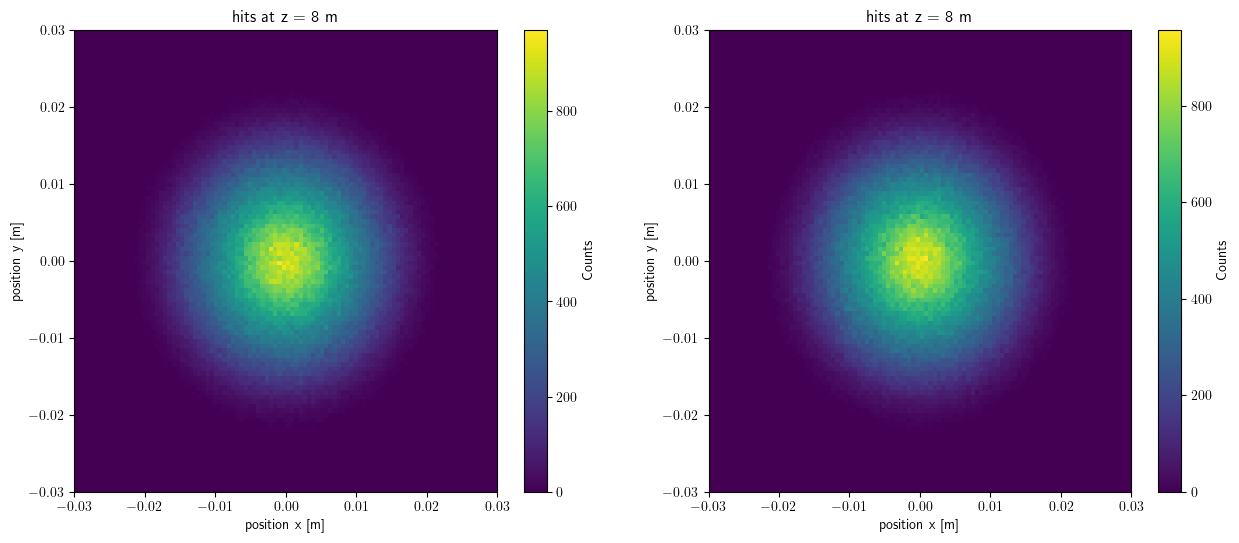

In [17]:
# this part is just to have a quick visual idea of the position of the μ at the beginning of the B field region
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_entrance["x"], R_mu_entrance["y"], bins=(100,100), range=[[-0.03,0.03],[-0.03,0.03]], cmap = "viridis")
colorbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
colorbar.set_label('Counts')
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
ax[0].set_title("hits at z = {} m".format(z_mag))

hist1 = ax[1].hist2d(R_anti_mu_entrance["x"], R_anti_mu_entrance["y"], bins=(100,100), range=[[-0.03,0.03],[-0.03,0.03]], cmap = "viridis")
colorbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
colorbar.set_label('Counts')
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")
ax[1].set_title("hits at z = {} m".format(z_mag))
plt.show()

### Code

In [18]:
# propagation of the muons and antimuons in the magnetic field
z_exit = L+z_mag # m
R_mu_exitB, P_mu_afterB = propagate_particles_in_Bfield(R_mu_entrance, P_mu, -1, z_exit, muon_mass, B, L)
R_anti_mu_exitB, P_antimu_afterB = propagate_particles_in_Bfield(R_anti_mu_entrance, P_anti_mu, +1, z_exit, muon_mass, B, L)

In [19]:
print("Muon momentum components at the exit of the magnetic field region:")
P_mu_afterB

Muon momentum components at the exit of the magnetic field region:


,x,y,z
0,1.045462,0.005782,27.346936
1,1.048691,-0.004837,19.278320
2,1.020431,-0.023830,28.289102
3,1.017134,-0.011196,17.465608
4,1.050497,0.005236,21.667272
...,...,...,...
999909,1.032713,0.010555,26.151421
999910,1.022667,0.019434,25.118791
999911,1.029010,0.008148,21.763389
999912,1.001360,0.020388,19.835048


In [20]:
print("Antimuon momentum components at the exit of the magnetic field region:")
P_antimu_afterB

Antimuon momentum components at the exit of the magnetic field region:


,x,y,z
0,-1.045462,-0.005782,20.201082
1,-1.048691,0.004837,30.309177
2,-1.020431,0.023830,19.299742
3,-1.017134,0.011196,30.018473
4,-1.050497,-0.005236,26.378209
...,...,...,...
999909,-1.032713,-0.010555,19.592607
999910,-1.022667,-0.019434,20.530746
999911,-1.029010,-0.008148,22.545331
999912,-1.001360,-0.020388,28.161608


#### Quick check

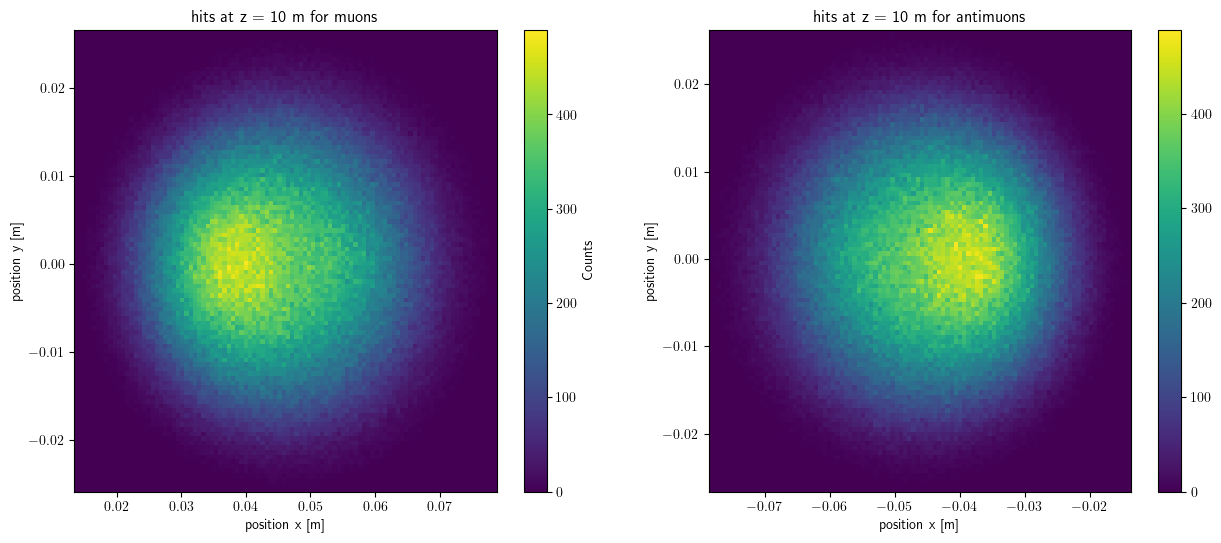

In [21]:
# plot to check the muons location at the exit of the magnetic field
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_exitB["x"], R_mu_exitB["y"], bins=(100,100), cmap = "viridis")
colorbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
colorbar.set_label('Counts')
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
ax[0].set_title("hits at z = {} m for muons".format(z_exit))

hist1 = ax[1].hist2d(R_anti_mu_exitB["x"], R_anti_mu_exitB["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")
ax[1].set_title("hits at z = {} m for antimuons".format(z_exit))

plt.show()

### Code

In [22]:
z_afterB_muons_detectors = np.array([12., 14., 16.]) # z of the silicon trackers after the magnetic field

r_afterB__muons_positions = {}
afterB_muons_detectors = {}
for z_new in z_afterB_muons_detectors:
    R_mu_tmp = propagate_particles(R_mu_exitB, P_mu_afterB, z_new, muon_mass)
    R_anti_mu_tmp = propagate_particles(R_anti_mu_exitB, P_antimu_afterB, z_new, muon_mass)
    data_tmp = {"mu": R_mu_tmp.copy(), "antimu": R_anti_mu_tmp.copy()}
    r_afterB__muons_positions[z_new] = data_tmp

Assuming square pixels of size 50.0x50.0 μm and a tolerance of 1.05 %:

for detector at z=12.0 m we choose:
 - length of 0.1356 m along x and 0.0652 m along y
 - center in (0.147, 0.0005) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 2712x1304 pixels

for detector at z=12.0 m we choose:
 - length of 0.1382 m along x and 0.0655 m along y
 - center in (-0.1458, -0.0002) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 2764x1310 pixels

for detector at z=14.0 m we choose:
 - length of 0.2076 m along x and 0.0726 m along y
 - center in (0.2448, 0.0005) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 4152x1452 pixels

for detector at z=14.0 m we choose:
 - length of 0.2115 m along x and 0.0728 m along y
 - center in (-0.2429, -0.0003) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 4230x1456 pixels

for detector at z=16.0 m we choose:
 - length of 0.2808 m along x and 0.08 m along y
 - c

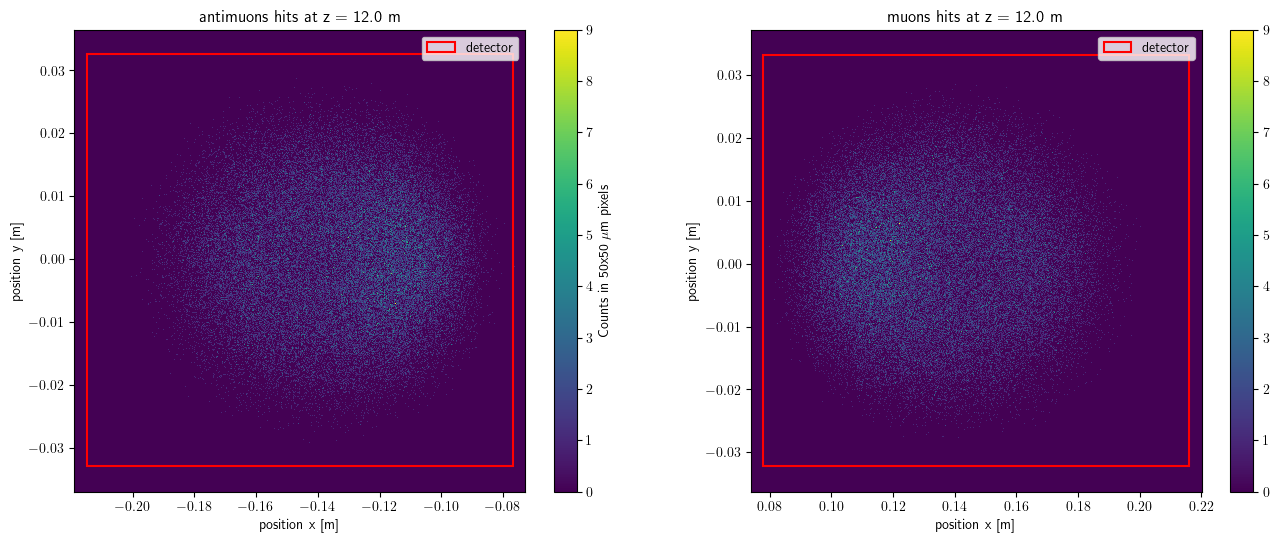

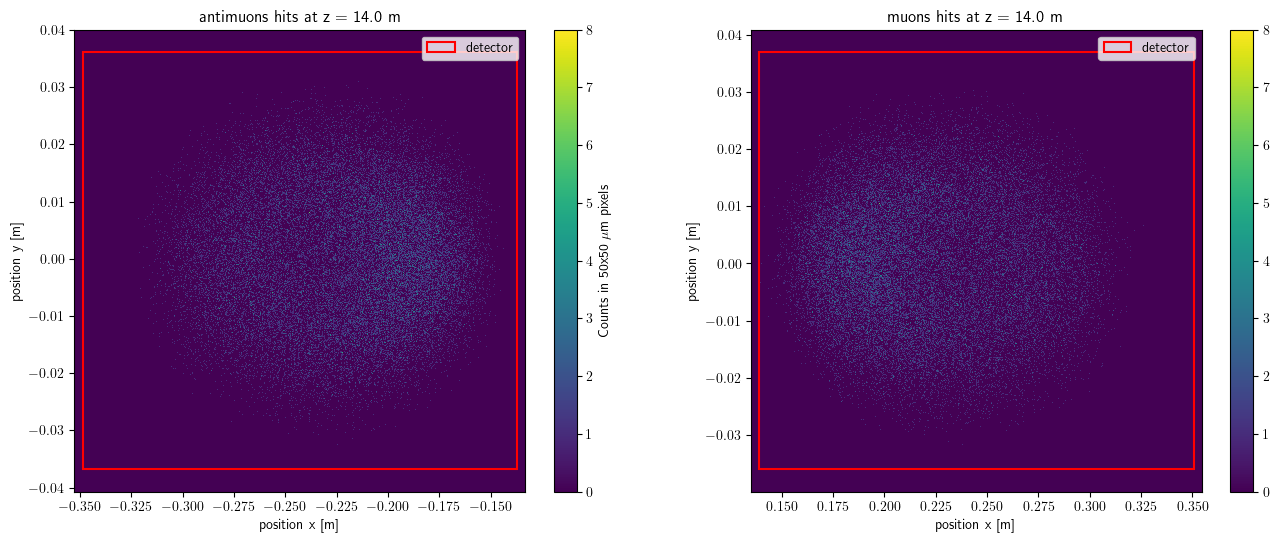

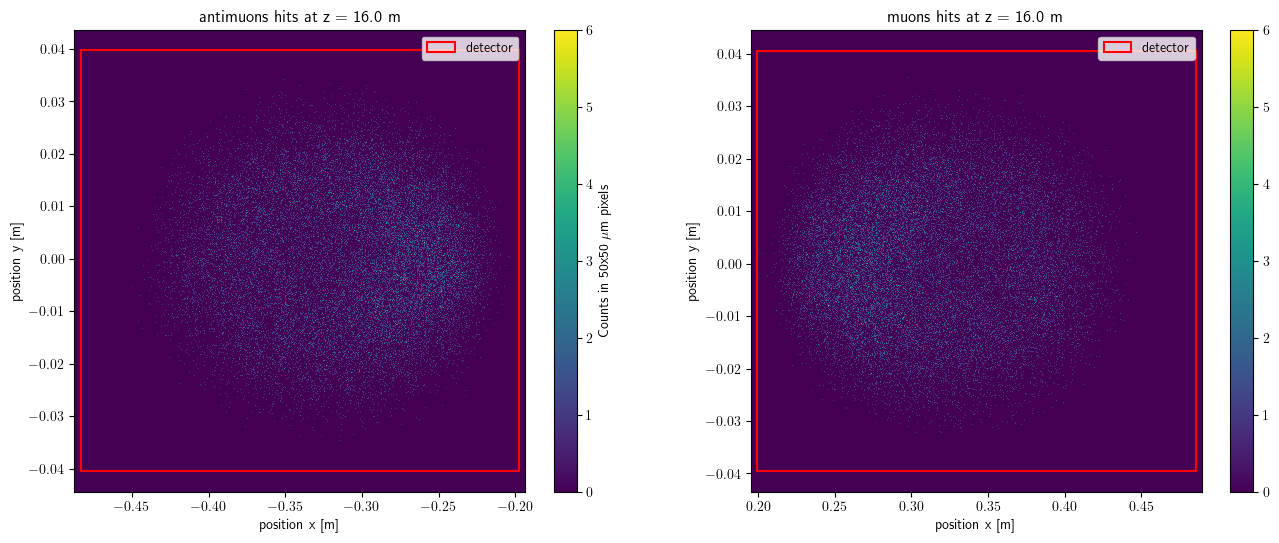

In [23]:
pixel_length = 50e-6 #m
tolerance = 1.05 #%
print(r"Assuming square pixels of size {}x{} μm and a tolerance of {} %:".format(pixel_length*1e6, pixel_length*1e6, tolerance))

for z_new, data in  r_afterB__muons_positions.items():
    # create hits map
    x_center_mu, y_center_mu, z_center_mu, x_length_mu, y_length_mu, pixel_length_mu = choose_detector_specs(data["mu"], tolerance, pixel_length)
    x_center_antimu, y_center_antimu, z_center_antimu, x_length_antimu, y_length_antimu, pixel_length_antimu = choose_detector_specs(data["antimu"], tolerance, pixel_length)

    x_length = max(x_length_mu, x_length_antimu)
    y_length = max(y_length_mu, y_length_antimu)
    
    edges_mu = get_edges(pixel_length_mu, x_center_mu, y_center_mu, x_length, y_length, 80)
    edges_antimu = get_edges(pixel_length_antimu, x_center_antimu, y_center_antimu, x_length, y_length, 80)

    detector_mu_tmp = Detector(x_center_mu, y_center_mu, z_center_mu, x_length, y_length, pixel_length)
    detector_mu_tmp.load_data(data["mu"])
    detector_antimu_tmp = Detector(x_center_antimu, y_center_antimu, z_center_antimu, x_length, y_length, pixel_length)
    detector_antimu_tmp.load_data(data["antimu"])
    
    detector_tmp = {
                    "mu": detector_mu_tmp,
                    "antimu": detector_antimu_tmp
                   }
    afterB_muons_detectors[z_new]=detector_tmp

    #plot hits maps
    df_positions_mu = detector_tmp["mu"].get_positions()
    df_positions_antimu = detector_tmp["antimu"].get_positions()
    fig, ax = plt.subplots(1, 2, figsize = (16, 6) )
    hist_muons = ax[1].hist2d(df_positions_mu["x"],df_positions_mu["y"], bins=edges_mu, cmap = "viridis")
    hist_antimuons = ax[0].hist2d(df_positions_antimu["x"], df_positions_antimu["y"], bins=edges_antimu, cmap = "viridis")

    colorbar = fig.colorbar(hist_muons[3], ax=ax[1], cmap="viridis")
    colorbar = fig.colorbar(hist_antimuons[3], ax=ax[0], cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    colorbar.set_label(r'Counts in {}x{} $\mu$m pixels'.format(pixel_length_label, pixel_length_label))
    labels = ["antimuons", "muons"]
    for a, lab in zip(ax, labels):
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(lab, z_new))
    place_detector_on_hitsmap(ax[1], x_center_mu, y_center_mu, x_length, y_length)
    place_detector_on_hitsmap(ax[0], x_center_antimu, y_center_antimu, x_length, y_length)

## Noise generation

### Helper functions

In [24]:
def extract_objects_from_dict(input_dict,label = ""):
    # this function is used to quickly retrieve muon and antimuon detectors from a dictionary
    
    output_dict = {}
    for key, value in input_dict.items():
        output_dict[key] = value[label]
    return output_dict

### Code

In [25]:
poisson_expected_value = 1
all_detectors = [
                  positron_detectors, 
                  upstream_muons_detectors, 
                  extract_objects_from_dict(afterB_muons_detectors,"mu"),
                  extract_objects_from_dict(afterB_muons_detectors,"antimu")
                ]

start_time = time.time()

for detector_dict in all_detectors:
    for det in detector_dict.values():
        det.generate_poisson_noise(poisson_expected_value)

end_time = time.time()
print("Time to generate noise: {} s".format(round((end_time - start_time),3)))

Time to generate noise: 10.641 s


## Tracking

### Tracks reconstruction
At this point, for a given trigger, it is possible to obtain the hits from each detector, both the physical ones and the noise. It is therefore necessary to reconstruct the tracks. Let's describe the situation well and try to understand how to tackle each problem separately. The tasks to be done are as follows:

- Identify the horizontal tracks of the positrons.
- Identify the tracks of the muons before the magnetic field; for each trigger there are 2 true tracks $\mu^+$ and $\mu^-$.
- Identify the tracks after the magnetic field; now separately for $\mu^+$ and $\mu^-$ (they hit separate detectors).
- Reconstruct the motion of the muons between before and after B. After B, it is known which particle is $\mu^+$ and which one is $\mu^-$. Before, however, it is not known and must be understood.

Let's tackle the various problems one at a time. First of all, how do we identify a track? A track is a set of hits in the same trigger on various detectors. Since there is noise, this will not be uniquely determined, but there will be various combinations among the hits of the detectors (noise and non-noise).
Let's first see the idea for fitting the points in space, regardless of whether they are given by muons or noise.
To perform the 3D fit, a particular strategy was chosen. We used PCA (Principal Component Analysis). If we perform a PCA with N points, the principal component will be precisely the direction that best describes the line passing through the points. While the value of the eigenvector relative to the principal component tells us how well this line we have identified describes the points. This allows us to solve another problem in one go. How do we understand if a track is real or noise? Since noise is random, the points will not be arranged in a straight line like for a muon (unless there is an unfortunate case, which occurs with low but non zero probability), so the variability described by the principal component will be less! To identify the n physical tracks we want, therefore, the n tracks where the principal component describes most of the variability are considered.

These are the foundational ideas behind track reconstruction. Let's now see how to apply them case by case.

#### Identifying the tracks of $e^+$
These particles travel perfectly in a straight line, so it will suffice to filter the possible tracks by requiring them to be straight (same $x$,$y$). Except for unfortunate cases, among all the options, there will be only one track that meets this condition, composed solely of true events and not noise. In this case, it is therefore not necessary to perform a fit to identify the positron.

#### Identifying the tracks of $\mu^+$ and $\mu^-$ before the magnetic field
Physical tracks are straight, so among the n possible combinations of hits, it is necessary to require that the $x$ and $y$ components of the hit pixels are either always increasing or always decreasing (muons cannot zigzag if no one deflects them). Among the tracks that satisfy this condition, the PCA criterion described earlier was then applied. Therefore, two tracks need to be reconstructed for each trigger, one for $\mu^+$ and one for $\mu^-$.

#### Identifying the tracks of $\mu^+$ and $\mu^-$ after the magnetic field
In this case, the same reasoning as before is applied, but now $\mu^+$ and $\mu^-$ hit to different detectors. Therefore, only one track per detector is required.


### Error on track reconstruction
To associate an error with each track, reasoning was based on the pixels used. The uncertainty of the direction will be given by the size of the pixels; since they are not point-like, they can identify at most an area where a particle has passed, not a precise point. The reasoning was applied for both polar angles describing the particle direction, but in the following diagrams, it was written only once for brevity on the $zx$ plane. Thus, a uniform distribution between the maximum and minimum angles due to the pixels was applied.
<center>
    <img src="./pictures/angle_error.PNG" alt="error_angle" width="600"/>  
</center>


### Helper functions

In [26]:
def get_possible_tracks(event_list, monotonic = True):
    # since the detectors are placed in the absence of a magnetic field, the traces can only be straight and monotonic 
    # traces (both increasing and decreasing) along all axes. Therefore, also considering the noise, 
    # I create all the possible tracks in the detectors, then select only those that are monotonous
    
    triplets = np.array(list(product(*event_list)))
    # Seleziona le triplette con valori crescenti o decrescenti su x e y
    selected_triplets = []
    
    if not monotonic:
        return triplets
        
    for triplet in triplets:
        x_values = np.array([np.round(triplet[i][0],8) for i in range(len(event_list))])
        y_values = np.array([np.round(triplet[i][1],8) for i in range(len(event_list))])
        
        # Verifica se le x e y sono in ordine crescente o decrescente
        if np.all(np.diff(x_values) >= 0) or np.all(np.diff(x_values) <= 0):
            if np.all(np.diff(y_values) >= 0) or np.all(np.diff(y_values) <= 0):
                selected_triplets.append(np.array(triplet))
    return np.array(selected_triplets)

In [27]:
def get_pixel_lists(detector_dic, trigger_number):
    # I take the list of pixels lit at a certain trigger number from all the detectors in question
    return [ det.get_trigger(trigger_number) for det in detector_dic.values()]

In [28]:
def get_straight_traces(traces):
    # I select all the tracks that go straight, since the positrons go perfectly straight
    count = 0
    straight_trace =[]
    for trace in traces:
        if (np.sum(trace[0][0] == trace[:,0]) == trace[:,0].shape[0]):
            if (np.sum(trace[0][1] == trace[:,1]) == trace[:,1].shape[0]):
                count = count + 1
                straight_trace.append(trace)
    straight_trace = np.array(straight_trace)
    if count == 1:
        return straight_trace[0]
    elif count > 1:
        print("ERROR: more than one straight track, positron lost, choosing randomly")
        n_straight_tracks = straight_trace.shape[0]
        indexes = np.arange(n_straight_tracks)
        random_index = np.random.choice(indexes)
        return straight_trace[random_index]
    elif count == 0:
        print("ERROR: positron not detected properly, no straight track found")
        return

In [29]:
def fit_line_3d(matrix):
    # using principal component analysis, I select the direction that best describes the points contained in the tracks
    
    matrix_t = matrix.T
    r0 = np.mean(matrix_t,axis=1)
    matrix_t_center = matrix_t - r0.reshape(3,1)

    cov = np.cov(matrix_t_center)
    result = sp.linalg.svd(cov)
    v0 = result[0][:,0]
    accuracy = result[1][0]/np.sum(result[1])
    
    return r0, v0, accuracy

In [30]:
def find_best_track(trace_list, n_traces = 1):
    # according the best fit, here we select choose which is the real track
    # among all the possible combinations
    
    fit_results = []
    fit_accuracies = []
    if len(trace_list.shape) == 2:
        trace_list = trace_list.reshape(1,trace_list.shape[0],trace_list.shape[1])
    for trace in trace_list:
        r0_tmp, v0_tmp, accuracy_tmp = fit_line_3d(trace)
        fit_results.append({"r0":r0_tmp, "v0":v0_tmp})
        fit_accuracies.append(accuracy_tmp)
    
    fit_accuracies = np.array(fit_accuracies)
    sorted_index = np.argsort(fit_accuracies)[::-1]
    if n_traces == 1:
        return [fit_results[sorted_index[0]]], [fit_accuracies[sorted_index[0]]], [trace_list[sorted_index[0]]]
    
    best_traces = trace_list[sorted_index[:n_traces]]
    best_fit_accuracies = fit_accuracies[sorted_index[:n_traces]]
    best_results = [fit_results[i] for i in sorted_index[:n_traces]]
    
    return best_results, best_fit_accuracies, best_traces 

In [31]:
def get_real_track(detector_list,trigger_number,label = "all"):
    # here we get the real track from all the Detectors
    real_pixels = np.array([det.get_real_events(trigger_number, label) for det in detector_list.values()])
    return real_pixels
    

In [32]:
def plot_3d_line_and_points(ro, v0, points):
    # this function is not part of the analysis. It's just useful
    # to check visually if the fit works 
    
    # ATTENTION: use %matplotlib ipympl when you use the function!
    # linspace parameter
    t = np.linspace(-10, 10, 100)

    # point to plot
    line_points = ro + np.outer(t, v0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], label='Points')
    ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], label='Line', color='red')

    # set graph
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    # show the graph
    plt.show()

In [33]:
def make_tracks_from_detector(detector_dict, trigger_initial=-1, trigger_final=-1, n_expected_tracks=-1, monotonic=True, straight=False):
    # function that uses all of the above in a for loop that loops trigger by trigger, and each time selects the most probable trace. 
    # The important thing is that the result is a dataframe that not only contains the traces obtained from the fit, but also the 
    # variable is_correct, which tells us whether the trace found is actually physical, and the variable real_particle, which tells 
    # us whether the selected trace belong to a muon or anti-muon
    
    # set good values for trigger initial and trigger fine 
    if trigger_initial == -1:
        trigger_initial = 0

    # check for a possible error on detector events dimention
    n_events = np.array([det.n_events for det in detector_dict.values()])
    if np.sum(n_events[0] == n_events) != n_events.shape:
        print("ERROR: in the detector dictionary provided the number of triggers in not the same: n_triggers = ", n_events)
        exit()

    if trigger_final == -1:
        trigger_final = n_events[0]
    elif trigger_final > n_events[0]:
        print("ERROR: trigger_final {} is bigger than n_events {} in the detector!".format(trigger_final,n_events[0]))

    if n_expected_tracks == -1:
        print("ERROR: you must provide the number of tracks you want to obtain from each trigger!")
        return

    # useful quantities for analysis
    z_values = list(detector_dict.keys())
    particles = list(detector_dict[z_values[0]].dataset_dict.keys())

    obtained_r0 = [ [] for i in range(n_expected_tracks)]
    obtained_v0 = [ [] for i in range(n_expected_tracks)]  
    obtained_is_correct = [ [] for i in range(n_expected_tracks)]
    real_label = [ [] for i in range(n_expected_tracks)]
    selected_tracks_list = [ [] for i in range(n_expected_tracks)]
    correct_tracks_list = []
    
    for trigger_number in tqdm(range(trigger_initial, trigger_final,1)):
        activated_pixels_in_each_detector = get_pixel_lists(detector_dict,trigger_number)
        possible_tracks = get_possible_tracks(activated_pixels_in_each_detector, monotonic = monotonic)
        if straight:
            possible_tracks = get_straight_traces(possible_tracks)
        fit_results, fit_accuracies, selected_tracks  = find_best_track(possible_tracks, n_expected_tracks)
        correct_tracks = np.array([get_real_track(detector_dict,trigger_number,label) for label in particles])
        for res, r0_list, v0_list, is_correct_list, track, real_label_list, select_track_l in zip(fit_results,obtained_r0,obtained_v0,obtained_is_correct,selected_tracks,real_label,selected_tracks_list):
            r0_list.append(res["r0"])
            v0_list.append(res["v0"])
            is_correct_list.append(any(np.array_equal(track, matrix) for matrix in correct_tracks))
            select_track_l.append(track)
            
            if n_expected_tracks > 1:
                real_muon_track = get_real_track(detector_dict,trigger_number,"n")
                real_antimuon_track = get_real_track(detector_dict,trigger_number,"p")
                if np.array_equal(track,real_muon_track):
                    real_label_list.append("mu")
                elif np.array_equal(track,real_antimuon_track):
                    real_label_list.append("anti-mu")
                else:
                    real_label_list.append("noise")
        
        correct_tracks_list.append(correct_tracks)



    obtained_r0 = np.array([ np.array(t) for t in obtained_r0 ])
    obtained_v0 = np.array([ np.array(t) for t in obtained_v0 ])
    obtained_is_correct = np.array([ np.array(t) for t in obtained_is_correct ])
    
    tracks_dataframes = []
    for i in range(n_expected_tracks):
        df_tmp = pd.DataFrame({
            'rx': obtained_r0[i][:,0],
            'ry': obtained_r0[i][:,1],
            'rz': obtained_r0[i][:,2],
            'vx': obtained_v0[i][:,0],
            'vy': obtained_v0[i][:,1],
            'vz': obtained_v0[i][:,2],
            'is_correct': obtained_is_correct[i][:]
        }) 

        if n_expected_tracks > 1:
            df_tmp["real_particle"] = real_label[i]

        tracks_dataframes.append(df_tmp)
    
    return tracks_dataframes, selected_tracks_list, correct_tracks_list

In [34]:
def write_list_on_file(file_name, list):
    # function to write a python list on a file
    with open(file_name, 'wb') as file:
        pickle.dump(list, file)
    return

In [35]:
def load_list_from_file(file_name):
    # function to load a python list from a file
    with open(file_name, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

In [36]:
def create_new_fit_result_folder(folder_name = "fit_results"):
    # function that creates a new folder for the fit results
    
    # Main folder path
    main_path = "./"

    # Full path
    full_path = os.path.join(main_path, folder_name)

    # Get the list of directory names
    directory_names = [name for name in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, name))]
    directory_names = [item for item in directory_names if "." not in item]
    # If directories are present, determine the maximum number
    if directory_names:
        folder_numbers = [int(name) for name in directory_names]
        new_number = max(folder_numbers) + 1
    else:
        # If no directories, start from 1
        new_number = 1

    # Create the new folder
    new_folder = os.path.join(full_path, str(new_number))
    os.makedirs(new_folder)

    return new_folder

In [37]:
def get_more_recent_fit_folder(which_cycle = -1, folder_name = "fit_results"):
    # function that returns a specific folder with the tracks results:
    # if which_cycle == -1 then returns the latest tracks results
    # if which_cycle == integer returns the returns the results of the correspondig tracks
    main_path = "./"

    # Full path
    full_path = os.path.join(main_path, folder_name)

    # Get the list of directory names
    directory_names = [name for name in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, name))]
    directory_names = [item for item in directory_names if "." not in item]
    # If directories are present, determine the maximum number
    if directory_names:
        folder_numbers = [int(name) for name in directory_names]
        if which_cycle == -1:
            return full_path + "/" + str(max(folder_numbers))
        else:
            return full_path + "/" + str(which_cycle)
    else:
        # If no directories, error
        print("ERROR: no fit results detected in folder", full_path)

    return

### Code

In [39]:
%%script echo cell skipped # comment this line if you want to execute this cell, if can takes a lot of time! up to 1 hour.
# here one by one we track the positrons and the muons, than we write the results in the fit_results folder 

# since this is a very long procedure, we leave here the output for only 20000 events, but the cell below will load the tracks with all the events from the fit_folder

n_events_to_analyze = 20000 # if -1 analyses all dataset
fit_folder = create_new_fit_result_folder()
print("The fit results will be printed in", fit_folder)
n_events_to_analyze = n_events_to_analyze if n_events_to_analyze != -1 else raw_data.shape[0] 

#analyze positrons
start_time = time.time()
df_positrons_fit, positrion_selected_tracks, positron_correct_tracks = make_tracks_from_detector(positron_detectors,0,n_events_to_analyze,1,False,True)
df_positrons_fit[0].to_csv(fit_folder + "/df_positrons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_positrons_selected_tracks.pkl",positrion_selected_tracks[0])
write_list_on_file(fit_folder + "/list_positrons_correct_tracks.pkl",positron_correct_tracks)
end_time = time.time()
print("Time for positrons: {} s, for {} events".format(end_time - start_time,n_events_to_analyze))

accuracy = np.sum(df_positrons_fit[0]["is_correct"].values)/df_positrons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)

#analyze muons before B

start_time = time.time()
df_upstream_muons_fit, upstream_muons_select_tracks, upstream_muons_correct_tracks = make_tracks_from_detector(upstream_muons_detectors,0,n_events_to_analyze,2,True,False)
df_upstream_muons_fit[0].to_csv(fit_folder + "/df_upstream_muons_0_fits.csv",index_label='relative_index')
df_upstream_muons_fit[1].to_csv(fit_folder + "/df_upstream_muons_1_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_upstream_muons_selected_0_tracks.pkl",upstream_muons_select_tracks[0])
write_list_on_file(fit_folder + "/list_upstream_muons_selected_1_tracks.pkl",upstream_muons_select_tracks[1])
write_list_on_file(fit_folder + "/list_upstream_muons_correct_tracks.pkl",upstream_muons_correct_tracks)
end_time = time.time()
print("Time for upstream muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_upstream_muons_fit[0]["is_correct"].values)/df_upstream_muons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)
accuracy = np.sum(df_upstream_muons_fit[1]["is_correct"].values)/df_upstream_muons_fit[1]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)

#analyze muons after B

start_time = time.time()
df_downstream_muons_fit, downstream_muons_selected_tracks, downstream_muons_correct_tracks = make_tracks_from_detector(extract_objects_from_dict(afterB_muons_detectors,"mu"),0,n_events_to_analyze,1,False,False)
df_downstream_muons_fit[0].to_csv(fit_folder + "/df_downstream_muons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_downstream_muons_selected_tracks.pkl",downstream_muons_selected_tracks[0])
write_list_on_file(fit_folder + "/list_downstream_muons_correct_tracks.pkl",downstream_muons_correct_tracks)
end_time = time.time()
print("Time for downstream muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_downstream_muons_fit[0]["is_correct"].values)/df_downstream_muons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification downstream muons:",accuracy)

start_time = time.time()
df_downstream_antimuons_fit, downstream_antimuons_selected_tracks, downstream_antimuons_correct_tracks = make_tracks_from_detector(extract_objects_from_dict(afterB_muons_detectors,"antimu"),0,n_events_to_analyze,1,False,False)
df_downstream_antimuons_fit[0].to_csv(fit_folder + "/df_downstream_antimuons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_downstream_antimuons_selected_tracks.pkl",downstream_antimuons_selected_tracks[0])
write_list_on_file(fit_folder + "/list_downstream_antimuons_correct_tracks.pkl",downstream_antimuons_correct_tracks)
end_time = time.time()
print("Time for downstream anti-muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_downstream_antimuons_fit[0]["is_correct"].values)/df_downstream_antimuons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification downstream anti-muons:",accuracy)

The fit results will be printed in ./fit_results/9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1132.02it/s]


Time for positrons: 18.194390773773193 s, for 20000 events
accuracy in tracks identification: 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:08<00:00, 290.38it/s]


Time for upstream muons: 69.41239857673645 s, for 20000 events
accuracy in tracks identification: 1.0
accuracy in tracks identification: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:31<00:00, 644.87it/s]


Time for downstream muons: 31.309593439102173 s, for 20000 events
accuracy in tracks identification downstream muons: 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:30<00:00, 656.91it/s]


Time for downstream anti-muons: 30.74285078048706 s, for 20000 events
accuracy in tracks identification downstream anti-muons: 1.0


In [40]:
# we load back the files from the folder. Ideally this box should not always be executed, but only if the tracks 
# have not been computed. We leave it this way so that the notebook can be run with just one click using the run 
# all function. In any case, Python is very fast at loading data from files so it doesn't slow down reloading the data every time.

# load data from files:
latest_fit_results_folder = get_more_recent_fit_folder()
print("loading data from folder", latest_fit_results_folder)

# load_positrons
df_positrons_fit = pd.read_csv(latest_fit_results_folder + "/df_positrons_fits.csv")
positrion_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_positrons_selected_tracks.pkl")
positrion_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_positrons_correct_tracks.pkl")

# load upstream muons
df_upstream_muons_fit = []
upstream_muons_selected_tracks = []
upstream_muons_correct_tracks = []
df_upstream_muons_fit.append(pd.read_csv(latest_fit_results_folder + "/df_upstream_muons_0_fits.csv"))
df_upstream_muons_fit.append(pd.read_csv(latest_fit_results_folder + "/df_upstream_muons_1_fits.csv"))
upstream_muons_selected_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_selected_0_tracks.pkl"))
upstream_muons_selected_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_selected_1_tracks.pkl"))
upstream_muons_correct_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_correct_tracks.pkl"))

for df in df_upstream_muons_fit:
    df["tracking_particle"] = ["to_do" for _ in range(df.shape[0])]

# load downstream muons

df_downstream_muons_fit = pd.read_csv(latest_fit_results_folder + "/df_downstream_muons_fits.csv")
df_downstream_muons_fit["real_particle"] = ["mu" for _ in range(df_downstream_muons_fit["is_correct"].values.shape[0])]
downstream_muons_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_muons_selected_tracks.pkl")
downstream_muons_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_muons_correct_tracks.pkl")

# load downstream anti-muons

df_downstream_antimuons_fit = pd.read_csv(latest_fit_results_folder + "/df_downstream_antimuons_fits.csv")
df_downstream_antimuons_fit["real_particle"] = ["anti-mu" for _ in range(df_downstream_antimuons_fit["is_correct"].values.shape[0])]
downstream_antimuons_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_antimuons_selected_tracks.pkl")
downstream_antimuons_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_antimuons_correct_tracks.pkl")

loading data from folder ./fit_results/10


## Identify muons and anti-muons before the magnetic field

## Match $\mu^+$ and $\mu^-$ before and after 
To match $\mu^+$ and $\mu^-$ before and after the magnetic field region, two methods have been implemented. One is based on momentum conservation, one on geometry considerations.

### Momentum conservation along y axis
For momentum conservation, it must be remembered that positrons have momentum only along the $z$-axis, while we assume that the electrons in the target they collide with are at rest. This means that the two generated muons must have opposite signs of momentum separately on the $x$-axis and $y$-axis. If in a potential pair of muon-antimuon both go upwards, or both go right then they do not conserve momentum, so they are either not muons or the tracks are poorly constructed. By applying this criterion, it is possible to first screen the obtained tracks, excluding any non-physical tracks. Then at this point, to match the tracks before and after, it is expected that if the muon after B goes "upwards" before B there will be a track going upwards, then the anti-muon after B will go downwards, and it is expected that before B there will be a track going downwards. However, since the direction of the muon is the result of the previous fit, it is not required that the sum of the momenta be exactly zero, this would require a perfect fit and point-like pixels, which physically makes no sense. We have limited ourselves to asking that the two muons have opposite signs of the $y$ components. This reasoning for matching the particles was applied only to the momentum along the $y$-axis because its component is not modified by B. In any case, to skim the events (so before the match between $\mu^+$ and $\mu^-$) and keep only the physical traces, this reasoning was applied on the $y$ axis before and after B, and on the $x$ axis before B. In doing so, some traces are excluded, but we work with a much more reliable dataset.

### Geometrical considerations

When the $y$-axis momentum technique cannot be used, i.e. for all muons that go perfectly along the $zx$ plane (within the limits of one pixel), we have developed a geometric technique which is represented in the figures below. As it is possible to see, the two distances in red are the same value (within an error due to the fit) only if the circumference is constructed with the correct pair of traces. Based on the difference between the two distances the correct track is chosen. One difference will be about zero, the other will be a number different from zero. At this point just select the pair with the smallest difference in absolute value.

<center>
    <img src="./pictures/geom_1.PNG" alt="geom_1" width="400"/> <img src="./pictures/geom_2.PNG" alt="geom_2" width="400"/> <img src="./pictures/geom_3.PNG" alt="geom_3" width="400"/>
</center>





### Helper functions

In [18]:
# functions used to know if traces can be considered physical. To better understand what it is for, refer to 
# the markdown description. The selection criterion cannot be explained exhaustively in a comment

def check_single_physical_pair(a,b):
    
    if a == 0 and b == 0:
        return True
    elif a==0 and b != 0:
        return False
    elif b==0 and a != 0:
        return False
    elif a != 0 and b != 0 and a*b < 0:
        return True
    elif a != 0 and b != 0 and a*b > 0:
        return False
    print("ERROR: the provided pair () is not in one of the possible expected cases!".format(a,b))
    

def identify_unphysical_pairs_using_momentum(df_0,df_1,label = "vy"):
    sign_tg_0 = np.sign((df_0[label]/df_0["vz"]).values)
    sign_tg_1 = np.sign((df_1[label]/df_1["vz"]).values)

    result = []
    for tg_0, tg_1 in zip(sign_tg_0,sign_tg_1):
        result.append(check_single_physical_pair(tg_0,tg_1))
    
    return np.array(result)

In [19]:
def match_muons_antimuons_vy(df_target, df_muons, df_antimuons):
    # function used to match muon and anti-muon after B with their track before B.
    # again check the markdown description to understand how it works and why.
    
    previous_labels = df_target["tracking_particle"].values
    physical_mask = df_target["physical_tracks"].values
    
    sign_tg_target = np.sign(df_target["vy"]/df_target["vz"])
    sign_tg_muons = np.sign(df_muons["vy"]/df_muons["vz"])
    sign_tg_antimuons = np.sign(df_antimuons["vy"]/df_antimuons["vz"])
    mask_muons = sign_tg_target * sign_tg_muons > 0
    mask_muons = mask_muons & physical_mask
    mask_antimuons = sign_tg_target * sign_tg_antimuons > 0
    mask_antimuons = mask_antimuons & physical_mask

    new_labels = []
    for l,m,a,p in zip(previous_labels,mask_muons, mask_antimuons, physical_mask):
        if not p:
            new_labels.append("lost")
        elif m:
            new_labels.append("mu")
        elif a:
            new_labels.append("anti-mu")

        else:
            new_labels.append(l)

    
    return np.array(new_labels)

In [20]:
def match_with_radius(df, df_mu, df_antimu,z_ini,z_exit,B):
    # this function is used to match all the remaining "to_do" matches, after the first matching criterion 
    # that exploits the y component of the momentum has been applied.
    # Since it is more complex it is implemented just for the pairs for which the first criterion was not successful.
    
    rx = df["rx"]
    ry = df["ry"]
    rz = df["rz"]
    vx = df["vx"] * np.sign(df["vz"])
    vy = df["vy"] * np.sign(df["vz"])
    vz = df["vz"] * np.sign(df["vz"])

    rx_mu = df_mu["rx"]
    ry_mu = df_mu["ry"]
    rz_mu = df_mu["rz"]
    vx_mu = df_mu["vx"] * np.sign(df_mu["vz"])
    vy_mu = df_mu["vy"] * np.sign(df_mu["vz"])
    vz_mu = df_mu["vz"] * np.sign(df_mu["vz"])

    rx_a_mu = df_antimu["rx"]
    ry_a_mu = df_antimu["ry"]
    rz_a_mu = df_antimu["rz"]
    vx_a_mu = df_antimu["vx"] * np.sign(df_antimu["vz"])
    vy_a_mu = df_antimu["vy"] * np.sign(df_antimu["vz"])
    vz_a_mu = df_antimu["vz"] * np.sign(df_antimu["vz"])

    q = rx-vx*rz/vz
    m = vx/vz
    x_ini = m*z_ini+q

    q_mu = rx_mu-vx_mu*rz_mu/vz_mu
    m_mu = vx_mu/vz_mu
    x_exit_mu = m_mu*z_exit+q_mu

    q_a_mu = rx_a_mu-vx_a_mu*rz_a_mu/vz_a_mu
    m_a_mu = vx_a_mu/vz_a_mu
    x_exit_a_mu = m_a_mu*z_exit+q_a_mu

    m_p = -1/m
    m_mu_p = -1/m_mu
    m_a_mu_p = -1/m_a_mu

    q_p = x_ini - m_p * z_ini
    q_mu_p = x_exit_mu - m_mu_p * z_exit
    q_a_mu_p = x_exit_a_mu - m_a_mu_p * z_exit

    z_center_mu = (q_mu_p-q_p)/(m_p - m_mu_p)
    x_center_mu = m_p * z_center_mu + q_p

    z_center_a_mu = (q_a_mu_p-q_p)/(m_p - m_a_mu_p)
    x_center_a_mu = m_p * z_center_a_mu + q_p

    r1_mu = np.sqrt( (x_ini-x_center_mu)**2 + (z_ini-z_center_mu)**2 )
    r2_mu = np.sqrt( (x_exit_mu-x_center_mu)**2 + (z_exit-z_center_mu)**2 )
    diff_mu = np.abs(r1_mu-r2_mu)

    r1_a_mu = np.sqrt( (x_ini-x_center_a_mu)**2 + (z_ini-z_center_a_mu)**2 )
    r2_a_mu = np.sqrt( (x_exit_a_mu-x_center_a_mu)**2 + (z_exit-z_center_a_mu)**2 )
    diff_a_mu = np.abs(r1_a_mu-r2_a_mu)

    out_values = diff_mu < diff_a_mu

    return np.array(["mu" if value else "anti-mu" for value in out_values.values])

### Code

In [21]:
# find non physical pairs of muons
is_physical_before_B_on_y = identify_unphysical_pairs_using_momentum(df_upstream_muons_fit[0],df_upstream_muons_fit[1],"vy")
is_physical_before_B_on_x = identify_unphysical_pairs_using_momentum(df_upstream_muons_fit[0],df_upstream_muons_fit[1],"vx")
is_physical_before_B = is_physical_before_B_on_x & is_physical_before_B_on_y

is_physical_after_B = identify_unphysical_pairs_using_momentum(df_downstream_muons_fit,df_downstream_antimuons_fit,"vy")
is_physical = is_physical_before_B & is_physical_after_B


for df in df_upstream_muons_fit:
    df["physical_tracks"] = is_physical

df_downstream_muons_fit["physical_tracks"] = is_physical

In [22]:
# match muons and antimuons when possible, otherwise set lost if it's a non physical pair, or to_do if our method is not enougth 
for df in df_upstream_muons_fit:
    df["tracking_particle"] = match_muons_antimuons_vy(df,df_downstream_muons_fit,df_downstream_antimuons_fit)

In [23]:
# match remaining particles using radius
to_do_mask = df_upstream_muons_fit[0]["tracking_particle"] == "to_do"
n_to_do_before = np.sum(to_do_mask.values)
print("there are {} events to match using the radius technique!".format(n_to_do_before))
if np.any(to_do_mask):
    labels_0 = match_with_radius(df_upstream_muons_fit[0][to_do_mask],df_downstream_muons_fit[to_do_mask],df_downstream_antimuons_fit[to_do_mask],z_mag,z_mag+L,B)
    labels_1 = match_with_radius(df_upstream_muons_fit[1][to_do_mask],df_downstream_muons_fit[to_do_mask],df_downstream_antimuons_fit[to_do_mask],z_mag,z_mag+L,B)
    same_particle_mask = labels_0 == labels_1 # case in which the radious technique does not work
    labels_0[same_particle_mask] = "to_do"
    labels_1[same_particle_mask] = "to_do"
    df_upstream_muons_fit[0].loc[to_do_mask, "tracking_particle"] = labels_0
    df_upstream_muons_fit[1].loc[to_do_mask, "tracking_particle"] = labels_1
    to_do_mask_after = df_upstream_muons_fit[0]["tracking_particle"] == "to_do"
    n_to_do_after = np.sum(to_do_mask_after.values)
    print("there are {} events left to match, so in these cases we have a {}% rate of success (apparently!)".format(n_to_do_after,round( (n_to_do_before-n_to_do_after)*100/n_to_do_before, 4)))

there are 1490 events to match using the radius technique!
there are 6 events left to match, so in these cases we have a 99.5973% rate of success (apparently!)


In [24]:
# check if the number of muons in df_0 is the same of anti-muons in df_1 and viceversa, otherwise there was an error in the pair creation process 
# get rows with trigger index and muon event
mask_muons_in_0 = df_upstream_muons_fit[0]["tracking_particle"] == "mu"
get_possible_anti_muons_in_1 = (df_upstream_muons_fit[1][mask_muons_in_0]["tracking_particle"] == "anti-mu").values # array of bools, if 1 --> anti-mu, if 0 --> something else
check_muon_antimuon_pairs = True if np.sum(get_possible_anti_muons_in_1)/get_possible_anti_muons_in_1.shape[0] == 1 else False

if check_muon_antimuon_pairs:
    print("The number of muons in df_0 is the same of anti-muons in df_1, check passed")
else:
    print("The number of muons in df_0 is NOT the same of anti-muons in df_1, check NOT passed --> ABORT")

# do the same but in the opposit way anti-muon in 0 and muon in 1
mask_anti_muons_in_0 = df_upstream_muons_fit[0]["tracking_particle"] == "anti-mu"
get_possible_muons_in_1 = (df_upstream_muons_fit[1][mask_anti_muons_in_0]["tracking_particle"] == "mu").values # array of bools, if 1 --> mu, if 0 --> something else
check_antimuon_muon_pairs = True if np.sum(get_possible_muons_in_1)/get_possible_muons_in_1.shape[0] == 1 else False

if check_antimuon_muon_pairs:
    print("The number of anti-muons in df_0 is the same of muons in df_1, check passed")
else:
    print("The number of anti-muons in df_0 is NOT the same of muons in df_1, check NOT passed --> ABORT")

# now check that these pairs are correctly matched according to the trigger number
triggers_mu_in_0 = df_upstream_muons_fit[0][df_upstream_muons_fit[0]["tracking_particle"] == "mu"]["relative_index"]
triggers_antimu_in_0 = df_upstream_muons_fit[0][df_upstream_muons_fit[0]["tracking_particle"] == "anti-mu"]["relative_index"]
triggers_mu_in_1 = df_upstream_muons_fit[1][df_upstream_muons_fit[1]["tracking_particle"] == "mu"]["relative_index"]
triggers_antimu_in_1 = df_upstream_muons_fit[1][df_upstream_muons_fit[1]["tracking_particle"] == "anti-mu"]["relative_index"]

# now every time there is a mu in 0 I want an anti mu in 1 and vice versa!
check_mu_antimu_match = True if np.sum((triggers_mu_in_0 == triggers_antimu_in_1).values)/(triggers_mu_in_0 == triggers_antimu_in_1).values.shape[0] == 1 else False
check_antimu_mu_match = True if np.sum((triggers_antimu_in_0 == triggers_mu_in_1).values)/(triggers_antimu_in_0 == triggers_mu_in_1).values.shape[0] == 1 else False

if check_mu_antimu_match:
    print("The muons-antimuons pairs are correctly matched according to the trigger number, check passed")
else:
    print("The muons-antimuons pairs are NOT correctly matched according to the trigger number, check NOT passed --> ABORT")

if check_antimu_mu_match:
    print("The antimuons-muons pairs are correctly matched according to the trigger number, check passed")
else:
    print("The antimuons-muons pairs are NOT correctly matched according to the trigger number, check NOT passed --> ABORT")

The number of muons in df_0 is the same of anti-muons in df_1, check passed
The number of anti-muons in df_0 is the same of muons in df_1, check passed
The muons-antimuons pairs are correctly matched according to the trigger number, check passed
The antimuons-muons pairs are correctly matched according to the trigger number, check passed


In [25]:
#check the quality of the identification obtained
# check how many times the tracking algorithm finds all the physical tracks among all possible combinations with noise.
# Pay attantion, this information does not enter into the analysis in any way, since it is not something that would be known in a real experiment
n_number_triggers = df_upstream_muons_fit[0].shape[0]
is_correct_upstream = df_upstream_muons_fit[0]["is_correct"].values & df_upstream_muons_fit[1]["is_correct"].values
is_correct_downstream = df_downstream_muons_fit["is_correct"].values & df_downstream_antimuons_fit["is_correct"].values
n_all_correct_tracks = is_correct_upstream & is_correct_downstream
fraction_all_correct_tracks = np.sum(n_all_correct_tracks)/n_number_triggers
print("The tracking algorithm finds all the correct tracks (muon and antimuons before and after B) {}% of the times".format(100*fraction_all_correct_tracks))

#check the percentage of the identified particles with respect to the total triggers and selectiong on physical pairs
df = df_upstream_muons_fit[0] # for brevity
apparently_identified_mask =  df["physical_tracks"].values & (df["tracking_particle"] != "to_do").values
apparently_identified_pairs = df[apparently_identified_mask]
apparently_identified_fraction = apparently_identified_pairs.shape[0]/df_upstream_muons_fit[0].shape[0]
print("We claim to have identified well {}% of the pairs".format(apparently_identified_fraction * 100))

# check how many of them we labelled correctly as muon/antimuon
correctly_identified_pairs = apparently_identified_pairs[ apparently_identified_pairs["tracking_particle"] == apparently_identified_pairs["real_particle"] ]
correctly_identified_fraction = correctly_identified_pairs.shape[0]/apparently_identified_pairs.shape[0]
print("Of this {}% of identified pairs, {}% of them are correctly identified as muon/anti-muon".format(round(apparently_identified_fraction*100,4),round(correctly_identified_fraction*100,4)))

The tracking algorithm finds all the correct tracks (muon and antimuons before and after B) 99.9845986754861% of the times
We claim to have identified well 98.79429630948262% of the pairs
Of this 98.7943% of identified pairs, 99.996% of them are correctly identified as muon/anti-muon


In [26]:
# add angles instead of versors to describe the tracks
all_tracks_fit = [df_upstream_muons_fit[0],df_upstream_muons_fit[1],df_downstream_muons_fit,df_downstream_antimuons_fit]

for df_tmp in all_tracks_fit:
    df_tmp["phi"] = np.arctan(df_tmp["vx"]/df_tmp["vz"])
    df_tmp["theta"] = np.arctan(df_tmp["vy"]/df_tmp["vz"])

In [27]:
# add phi and theta error according to a uniform distribution
def find_angle_error(track_list,pixel_length,index):
    alpha_errors = []

    for track in tqdm(track_list):
        d_i = track[0]
        d_f = track[track.shape[0]-1]
        numerator_1_tan = d_f[index] + pixel_length/2 - (d_i[index] - pixel_length/2)
        numerator_2_tan = d_f[index] - pixel_length/2 - (d_i[index] + pixel_length/2)
        denominator_tan = d_f[2]-d_i[2]
        alpha_1 = np.arctan(numerator_1_tan/denominator_tan)
        alpha_2 = np.arctan(numerator_2_tan/denominator_tan)
        alpha_errors.append(np.abs(alpha_1-alpha_2)/np.sqrt(12))
        
    return alpha_errors

In [28]:
all_selected_tracks = [ upstream_muons_selected_tracks[0], upstream_muons_selected_tracks[1],downstream_muons_selected_tracks, downstream_antimuons_selected_tracks ]
print("total number of iterations to do:", len(all_selected_tracks)*2)
for df_tmp, track_tmp in zip(all_tracks_fit,all_selected_tracks):
    df_tmp["phi_error"] = find_angle_error(track_tmp, 50e-6, 0) # 0 is the index for the x component
    df_tmp["theta_error"] = find_angle_error(track_tmp, 50e-6, 1) # 1 in the index for the y component

total number of iterations to do: 8


100%|███████████████████████████████| 999914/999914 [00:05<00:00, 192778.38it/s]


## Data reorganisation for the analysis

Before proceding with the reconstruction of the particles' momenta, the particles that were properly identified before the magnetic field are reorganised according to their type in two new DataFrames. Moreover, according to the trigger number, only the muons and antimuons after the magnetic field that were properly associated with the correspondent tracks before the magnetic field are selected.

In [29]:
# the events for each reconstructed track before the magnetic field are filtered 
# and reorganised in two new DataFrames according to their type
tmp_df_upstream_muons_0 = df_upstream_muons_fit[0][apparently_identified_mask].copy()
mask_anti_mu_0 = (tmp_df_upstream_muons_0["tracking_particle"]=="anti-mu").values
data_mu_beforeB = df_upstream_muons_fit[0][apparently_identified_mask].copy()
data_mu_beforeB[mask_anti_mu_0] = df_upstream_muons_fit[1][apparently_identified_mask][mask_anti_mu_0]

data_antimu_beforeB = df_upstream_muons_fit[1][apparently_identified_mask].copy()
data_antimu_beforeB[mask_anti_mu_0] = tmp_df_upstream_muons_0[mask_anti_mu_0]

# the simulated events that correspond to the apparently identified events are stored in a DataFrame.
# This is used later for the plots
n_events = df_upstream_muons_fit[0].shape[0]
simulated_events = raw_data.loc[:n_events-1,:]
simulated_events = simulated_events[apparently_identified_mask]

In [30]:
print("The events in the first dataframe after the application of the apparently_identified mask: ")
tmp_df_upstream_muons_0.head(5)

The events in the first dataframe after the application of the apparently_identified mask: 


,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.011475,0.000892,5.0,-0.000950,-0.000212,-1.000000,True,mu,mu,True,0.000950,0.000212,0.000007,0.000007
1,1,0.005808,0.004625,5.0,-0.001512,0.000250,-0.999999,True,mu,mu,True,0.001512,-0.000250,0.000007,0.000007
2,2,0.002125,-0.008725,5.0,-0.000050,0.000850,-1.000000,True,mu,mu,True,0.000050,-0.000850,0.000007,0.000007
3,3,0.007925,0.006125,5.0,-0.000075,-0.000375,-1.000000,True,anti-mu,anti-mu,True,0.000075,0.000375,0.000007,0.000007
4,4,-0.001025,-0.006225,5.0,-0.001175,-0.000200,0.999999,True,anti-mu,anti-mu,True,-0.001175,-0.000200,0.000007,0.000007


In [31]:
print("The events in the second dataframe after the application of the apparently_identified mask: ")
df_upstream_muons_fit[1][apparently_identified_mask].head(5)

The events in the second dataframe after the application of the apparently_identified mask: 


,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.000242,-0.001592,5.0,-0.001287,-0.000287,0.999999,True,anti-mu,anti-mu,True,-0.001287,-0.000287,0.000007,0.000007
1,1,-0.006658,0.006692,5.0,-0.000962,0.000162,1.000000,True,anti-mu,anti-mu,True,-0.000962,0.000162,0.000007,0.000007
2,2,0.001625,0.001625,5.0,-0.000050,0.001225,0.999999,True,anti-mu,anti-mu,True,-0.000050,0.001225,0.000007,0.000007
3,3,0.006975,0.001075,5.0,-0.000125,-0.000650,1.000000,True,mu,mu,True,-0.000125,-0.000650,0.000007,0.000007
4,4,0.012042,-0.004008,5.0,-0.001437,-0.000237,-0.999999,True,mu,mu,True,0.001437,0.000237,0.000007,0.000007


In [32]:
# DataFrame containing all the apparently identified muons before the magnetic field
print("The apparently_identified muon events before the magnetic field region: ")
data_mu_beforeB.head(5)

The apparently_identified muon events before the magnetic field region: 


,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.011475,0.000892,5.0,-0.000950,-0.000212,-1.000000,True,mu,mu,True,0.000950,0.000212,0.000007,0.000007
1,1,0.005808,0.004625,5.0,-0.001512,0.000250,-0.999999,True,mu,mu,True,0.001512,-0.000250,0.000007,0.000007
2,2,0.002125,-0.008725,5.0,-0.000050,0.000850,-1.000000,True,mu,mu,True,0.000050,-0.000850,0.000007,0.000007
3,3,0.006975,0.001075,5.0,-0.000125,-0.000650,1.000000,True,mu,mu,True,-0.000125,-0.000650,0.000007,0.000007
4,4,0.012042,-0.004008,5.0,-0.001437,-0.000237,-0.999999,True,mu,mu,True,0.001437,0.000237,0.000007,0.000007


In [33]:
# DataFrame containing all the apparently identified antimuons before the magnetic field
print("The apparently_identified antimuon events before the magnetic field region: ")
data_antimu_beforeB.head(5)

The apparently_identified antimuon events before the magnetic field region: 


,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.000242,-0.001592,5.0,-0.001287,-0.000287,0.999999,True,anti-mu,anti-mu,True,-0.001287,-0.000287,0.000007,0.000007
1,1,-0.006658,0.006692,5.0,-0.000962,0.000162,1.000000,True,anti-mu,anti-mu,True,-0.000962,0.000162,0.000007,0.000007
2,2,0.001625,0.001625,5.0,-0.000050,0.001225,0.999999,True,anti-mu,anti-mu,True,-0.000050,0.001225,0.000007,0.000007
3,3,0.007925,0.006125,5.0,-0.000075,-0.000375,-1.000000,True,anti-mu,anti-mu,True,0.000075,0.000375,0.000007,0.000007
4,4,-0.001025,-0.006225,5.0,-0.001175,-0.000200,0.999999,True,anti-mu,anti-mu,True,-0.001175,-0.000200,0.000007,0.000007


In [34]:
# selection of the properly identified particles in the dataframes of the downstream muon detectors
data_mu_afterB = df_downstream_muons_fit[apparently_identified_mask]
data_antimu_afterB = df_downstream_antimuons_fit[apparently_identified_mask]

In [35]:
# selected muons after the magnetic field region
print("The correspondent apparently_identified muon events after the magnetic field region: ")
data_mu_afterB.head(5)

The correspondent apparently_identified muon events after the magnetic field region: 


,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.206425,0.002792,14.0,-0.038197,-0.000212,-0.999270,True,mu,True,0.038206,0.000212,0.000007,0.000007
1,1,0.283825,0.002375,14.0,-0.054320,0.000250,-0.998524,True,mu,True,0.054346,-0.000250,0.000007,0.000007
2,2,0.182625,-0.016308,14.0,-0.036052,0.000837,-0.999350,True,mu,True,0.036059,-0.000837,0.000007,0.000007
3,3,0.297592,-0.004692,14.0,-0.058139,0.000636,-0.998308,True,mu,True,0.058172,-0.000637,0.000007,0.000007
4,4,0.260175,-0.001842,14.0,-0.048418,-0.000237,-0.998827,True,mu,True,0.048437,0.000237,0.000007,0.000007


In [36]:
# selected antimuons after the magnetic field region
print("The correspondent apparently_identified antimuon events after the magnetic field region: ")
data_antimu_afterB.head(5)

The correspondent apparently_identified antimuon events after the magnetic field region: 


,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,phi,theta,phi_error,theta_error
0,0,-0.263658,-0.004175,14.0,-0.051693,-0.000275,0.998663,True,anti-mu,-0.051716,-0.000275,0.000007,0.000007
1,1,-0.183525,0.008142,14.0,-0.034579,0.000162,0.999402,True,anti-mu,-0.034586,0.000162,0.000007,0.000007
2,2,-0.262925,0.012725,14.0,-0.052801,0.001223,0.998604,True,anti-mu,-0.052826,0.001225,0.000007,0.000007
3,3,-0.161192,0.009475,14.0,-0.033868,0.000375,0.999426,True,anti-mu,-0.033875,0.000375,0.000007,0.000007
4,4,-0.204875,-0.007975,14.0,-0.039793,-0.000200,0.999208,True,anti-mu,-0.039804,-0.000200,0.000007,0.000007


## Reconstruction of the particles' momentum

Considering the entrance and exit 2D vector in the $zx$ plane, 
$\overrightarrow{v}_\mathrm{entrance}$
 and 
$\overrightarrow{v}_\mathrm{exit}$,
the rotation angle between them is given by:
$$ \theta=acos\Bigg(\frac{\overrightarrow{v}_\mathrm{entrance}\cdot \overrightarrow{v}_\mathrm{exit}}{|\overrightarrow{v}_\mathrm{entrance}||\overrightarrow{v}_\mathrm{exit}|}\Bigg). $$
Knowing the rotation angle and the length of the chord described by the particle in the magnetic field in the $zx$ plane
$$len(\overline{EE'})=\sqrt{(x_\mathrm{E'}-x_\mathrm{E})^2 + (z_\mathrm{E'}-z_\mathrm{E})^2},$$ it is possible to obtain, by means of the chord theorem, the radius of the arc of circumference described by the particle:
$$ len(\overline{EE'})=2R\sin\Bigg(\frac{\theta}{2}\Bigg) 
\qquad
\Rightarrow
\qquad
R=\frac{1}{2}len(\overline{EE'})\cdot \frac{1}{\sin\Big( \frac{\theta}{2} \Big)}.
$$ 
From the radius it is possible to reconstruct, knowing the charge $q=1$ of the particle and the magnetic field $B$, the momentum component on the $zx$ plane: 
$$ P_{zx}=qBR. $$
Then, knowing the length of the arc of circumference on the $zx$ plane, $len(arc)=R\theta$, where $\theta$ is expressed in radians, it is possible to estimate the amount of time that the particle spends in the magnetic field:
$$ t = \frac{len(arc)  m_\mu}{P_{zx}}, $$
and then the $y$ component of the momentum from:
$$ P_y=\frac{(y_\mathrm{E'}-y_\mathrm{E})  m_\mu}{t} . $$
The total momentum of the particle is given by:
$$P_\mathrm{tot}=\sqrt{P_{zx}^2 + P_y^2}. $$
The uncertainty on each quantity is obtained using the propagation of errors.

### Helper functions

In [37]:
# ##########################
# #   GEOMETRIC FUNCTIONS  #
# ##########################
  
def get_distance_2D(p1, p2):
    # this function is used to get the (2D) distance between two points, p1 and p2, in the zx plane.
    # It also provides the uncertainty on the distance obtained from the propagation of the uncertainty on the coordinates
    # p1 and p2 are two DataFrames in which the coordinates and their errors are saved.
    delta_x = p1["x"]-p2["x"]
    dist = np.sqrt( (delta_x)**2 + (p1["z"]-p2["z"])**2 )
    dist_error = np.sqrt( (delta_x/dist)**2 *((p1["x_error"])**2 + (p2["x_error"])**2) )
    
    return dist, dist_error


def get_3Dpoint_at_z(tracks, z_coord, pixel_length):
    # this function calculates the x and y coordinates knowing the track of interest and the z point at which the calculation needs to be done.
    # It takes as input the DataFrame containing the information on the tracks (one point of the track and the direction vector).
    # It returns a DataFrame containing the coordinates of the searched point and their errors
    intercept_x = -tracks["rz"]*tracks["phi"]+tracks["rx"]
    err_rx = pixel_length/np.sqrt(12)
    err_intercept_x = np.sqrt( (tracks["rz"]*tracks["phi_error"])**2 + (err_rx)**2 )
    
    intercept_y = -tracks["rz"]* tracks["theta"]+tracks["ry"]
    err_ry = pixel_length/np.sqrt(12)
    err_intercept_y = np.sqrt( (tracks["rz"]*tracks["theta_error"])**2 + (err_ry)**2 )
    
    ordinate_x = tracks["phi"]*z_coord+intercept_x
    err_ordinate_x = np.sqrt( (tracks["phi_error"]*tracks["rz"])**2 + (err_intercept_x)**2 )
    ordinate_y =  tracks["theta"]*z_coord+intercept_y
    err_ordinate_y = np.sqrt( (tracks["theta_error"]*tracks["rz"])**2 + (err_intercept_y)**2 )
    z_coord_array = np.ones((tracks.shape[0]))*z_coord
    point = pd.DataFrame({"x": ordinate_x, 
                          "x_error": err_ordinate_x,
                          "y": ordinate_y, 
                          "y_error": err_ordinate_y,
                          "z": z_coord_array})
    
    return point

In [38]:
# #########################################
# #   MOMENTUM RECONSTRUCTION FUNCTION    #
# #########################################

def get_momenta(entrance_tracks, exit_tracks, B, pixel_length):
    # this functions implements the momentum reconstruction.
    # It takes as input the DataFrame of the entrance and exit tracks and the magnetic field.
    # It returns a DataFrame containing the information on the zx and y components of the momentum 
    # and the total reconstructed momentum for a given particle with its estimated uncertainty.
    # It also computes the x and z component of the momentum at the exit of the magnetic field region
    # and tehis uncertainties.
    # It also returns the rotation angle that can be used for a check

    rotation_angle = np.abs(exit_tracks["phi"]-entrance_tracks["phi"]) # --> taken always positive to ease the calculations
    rotation_angle_error = np.sqrt( (exit_tracks["phi_error"])**2 + (entrance_tracks["phi_error"])**2 )
    
    entrance_point = get_3Dpoint_at_z(entrance_tracks, z_mag, pixel_length)
    exit_point = get_3Dpoint_at_z(exit_tracks, z_mag+L, pixel_length)
    
    chord_length, chord_length_error = get_distance_2D(entrance_point, exit_point)
    radius = chord_length/(2*np.sin(rotation_angle/2))
    radius_error = radius*np.sqrt( (rotation_angle_error/(2*np.tan(rotation_angle/2)))**2 + (chord_length_error/chord_length)**2 )

    arc_length = radius*rotation_angle
    arc_length_error = np.sqrt( (radius*rotation_angle_error)**2 + (radius_error*rotation_angle)**2 )
    P_xz = radius*B*c/1e9
    P_xz_error = radius_error*B*c/1e9
    time = arc_length/P_xz
    time_error = 1e9/(B*c)*rotation_angle_error

    delta_y = exit_point["y"]-entrance_point["y"]
    delta_y_error = np.sqrt( (exit_point["y_error"])**2 + (entrance_point["y_error"])**2 )
    P_y = (delta_y) / time
    P_y_error = np.abs(P_y)*np.sqrt( (delta_y_error/delta_y)**2 + (time_error/time)**2 )

    P_tot = np.sqrt(P_y**2 + P_xz**2)
    P_tot_error = 1/P_tot * np.sqrt( (P_y*P_y_error)**2 + (P_xz*P_xz_error)**2 )
    
    P_x_ent = P_xz*np.sin(entrance_tracks["phi"])
    P_x_ent_error = np.sqrt( (P_xz_error*np.sin(entrance_tracks["phi"]))**2 + (P_xz*np.cos(entrance_tracks["phi"])*entrance_tracks["phi_error"])**2 )
    P_z_ent = P_xz*np.cos(entrance_tracks["phi"])
    P_z_ent_error = np.sqrt( (P_xz_error*np.cos(entrance_tracks["phi"]))**2 + (P_xz*np.sin(entrance_tracks["phi"])*entrance_tracks["phi_error"])**2 )

    P_x_exit = P_xz*np.sin(exit_tracks["phi"])
    P_x_exit_error = np.sqrt( (P_xz_error*np.sin(exit_tracks["phi"]))**2 + (P_xz*np.cos(exit_tracks["phi"])*exit_tracks["phi_error"])**2 )
    P_z_exit = P_xz*np.cos(exit_tracks["phi"])
    P_z_exit_error = np.sqrt( (P_xz_error*np.cos(exit_tracks["phi"]))**2 + (P_xz*np.sin(exit_tracks["phi"])*exit_tracks["phi_error"])**2 )

    P_reconstructed = pd.DataFrame({"P_x_ent": P_x_ent, 
                                    "P_x_ent_err": P_x_ent_error, 
                                    "P_x_exit": P_x_exit, 
                                    "P_x_exit_err": P_x_exit_error, 
                                    "P_y": P_y,
                                    "P_y_err": P_y_error,
                                    "P_z_ent": P_z_ent, 
                                    "P_z_ent_err": P_z_ent_error,
                                    "P_z_exit": P_z_exit, 
                                    "P_z_exit_err": P_z_exit_error,
                                    "P_tot": P_tot, 
                                    "P_tot_err": P_tot_error})

    return P_reconstructed, rotation_angle

In [39]:
# ##########################
# #   PLOTTING FUNCTIONS   #
# ##########################

def plot_momentum(rec_mu, rec_antimu, sim_mu, sim_antimu, nBins, p_start, p_stop):
    # this function takes as input the Dataframes of the reconstructed momentum for muons and antimuons
    # and the DataFrames containing the results of the simulation for muons and antimuons momentum.
    # It displays two plots (one for muons and one for antimuons) containing the comparison 
    # between the reconstructed total momentum and the total momentum from the simulation.
    # It also takes as input parameters the number of bins in which the range [p_start, p_stop] will be divided.
    
    fig, ax = plt.subplots(1, 2, figsize=(18,7))
    bin_width = (p_stop-p_start)/nBins
    
    ax[0].hist(rec_mu, bins=nBins, range=[p_start, p_stop], color='orange', label="Reconstructed momentum")
    ax[0].hist(sim_mu, bins=nBins, range=[p_start, p_stop], color='blue', lw=2, histtype='step', label="Simulation")
    ax[1].hist(rec_antimu, bins=nBins, range=[p_start, p_stop], color='orange',  label="Reconstructed momentum")
    ax[1].hist(sim_antimu, bins=nBins, range=[p_start, p_stop], color='blue', lw=2, histtype='step', label="Simulation")

    ax[0].set_title('Comparison of momenta for muons', fontsize=18)
    ax[1].set_title('Comparison of momenta for antimuons', fontsize=18)

    ax[0].set_xlabel("Momentum [GeV]", fontsize=14)
    ax[0].set_ylabel("Counts / {} GeV".format(round(bin_width,2)), fontsize=14)
    ax[1].set_xlabel("Momentum [GeV]", fontsize=14)
    ax[1].set_ylabel("Counts / {} GeV".format(round(bin_width,2)), fontsize=14)
    
#    ax[0].set_yscale("log")
#    ax[1].set_yscale("log")
    
    ax[0].legend()
    ax[1].legend()
    plt.show()
    
    return

def get_outliers_mask(n_sigma, data):
    mean = np.mean(data)
    std = np.std(data)
    mask = np.abs(data) < (mean+ std*n_sigma)
    return mask
    

def plot_momentum_components_residuals(rec_mu, rec_antimu, sim_events, nBins, n_sigma_out = 5):
    # this function takes as input the DataFrames containing the reconstructed momentum, 
    # and in particular all the reconstructed components for muons and antimuons
    # and the DataFrame containing the raw data of the simulation.
    # It displays a plot for each momentum component and for both muons and antimuons separately
    # showing the residuals between the reconstructed momentum component and the simulated momentum component.
    # The binning is chosen according to the number of bins passed by the user and the spread of the residuals for each component.
    
    fig, ax = plt.subplots(2, 3, figsize=(20,14))
    
    res_mu_px = (rec_mu["P_x_ent"]-sim_events["px_mu1"]).values
    res_mu_py = (rec_mu["P_y"]-sim_events["py_mu1"]).values
    res_mu_pz = (rec_mu["P_z_ent"]-sim_events["pz_mu1"]).values
    res_antimu_px = (rec_antimu["P_x_ent"]-sim_events["px_mu2"]).values
    res_antimu_py = (rec_antimu["P_y"]-sim_events["py_mu2"]).values
    res_antimu_pz = (rec_antimu["P_z_ent"]-sim_events["pz_mu2"]).values

    res_list = [res_mu_px, res_mu_py, res_mu_pz, res_antimu_px, res_antimu_py, res_antimu_pz]

    mask_for_outliers = np.array([True for _ in range(res_mu_px.shape[0])])
    for res in res_list:
        mask_tmp = get_outliers_mask(n_sigma_out, res)
        mask_for_outliers = mask_for_outliers & mask_tmp

    label_list = ["Muon $p_x$", "Muon $p_y$", "Muon $p_z$", "Antimuon $p_x$", "Antimuon $p_y$", "Antimuon $p_z$"]

    for i in range(2):
        for j in range(3):
            hist, bin_edges, _ = ax[i,j].hist(res_list[i*3+j][mask_for_outliers],bins = nBins, color='blue', alpha=0.7)
            bin_width = bin_edges[1]-bin_edges[0]
            ax[i,j].set_xlabel("{} residuals [GeV]".format(label_list[i*3+j]), fontsize=14)
            ax[i,j].set_ylabel("Counts / {} GeV".format(round(bin_width,5)), fontsize=14)
            ax[i,j].xaxis.set_major_locator(MaxNLocator(5))
            #ax[i,j].set_yscale('log')

    fig.suptitle("Momentum residual along the different directions", fontsize=18)
    plt.show()
    
    return mask_for_outliers

### Code

In [40]:
pixel_length = 50e-6

# the following lines provide the momentum reconstruction for muons and antimuons
mu_reconstructed_P, mu_rot_angle = get_momenta(data_mu_beforeB, data_mu_afterB, B, pixel_length)
antimu_reconstructed_P, antimu_rot_angle = get_momenta(data_antimu_beforeB, data_antimu_afterB, B, pixel_length)

In [41]:
print("Reconstructed momentum for the muons: \n")
mu_reconstructed_P.head(5)

Reconstructed momentum for the muons: 



,P_x_ent,P_x_ent_err,P_x_exit,P_x_exit_err,P_y,P_y_err,P_z_ent,P_z_ent_err,P_z_exit,P_z_exit_err,P_tot,P_tot_err
0,0.025997,0.000198,1.045293,0.000347,0.005643,0.002094,27.365752,0.007490,27.345793,0.007485,27.365765,0.007490
1,0.029195,0.000139,1.048492,0.000245,-0.004823,0.001477,19.302228,0.003723,19.273752,0.003717,19.302251,0.003723
2,0.001416,0.000204,1.020710,0.000354,-0.023825,0.002167,28.312514,0.008019,28.294109,0.008013,28.312524,0.008019
3,-0.002187,0.000126,1.017111,0.000218,-0.011074,0.001338,17.494475,0.003057,17.464883,0.003052,17.494478,0.003057
4,0.031188,0.000157,1.050485,0.000276,0.005467,0.001660,21.696076,0.004705,21.670652,0.004700,21.696099,0.004705


In [42]:
print("Reconstructed momentum for the antimuons: \n")
antimu_reconstructed_P.head(5)

Reconstructed momentum for the antimuons: 



,P_x_ent,P_x_ent_err,P_x_exit,P_x_exit_err,P_y,P_y_err,P_z_ent,P_z_ent_err,P_z_exit,P_z_exit_err,P_tot,P_tot_err
0,-0.026036,0.000146,-1.045332,0.000256,-0.006274,0.001547,20.221794,0.004087,20.194775,0.004081,20.221812,0.004087
1,-0.029184,0.000219,-1.048479,0.000386,0.004737,0.002320,30.320982,0.009197,30.302863,0.009192,30.320996,0.009197
2,-0.000966,0.000139,-1.020263,0.000241,0.024384,0.001478,19.322714,0.003731,19.295760,0.003726,19.322730,0.003731
3,0.002252,0.000217,-1.017042,0.000374,0.010884,0.002298,30.029547,0.009022,30.012320,0.009017,30.029549,0.009022
4,-0.031013,0.000191,-1.050309,0.000336,-0.004618,0.002020,26.393985,0.006967,26.373097,0.006962,26.394003,0.006967


In the following the reconstructed momentum for muons and antimuons is compared with the simulation:


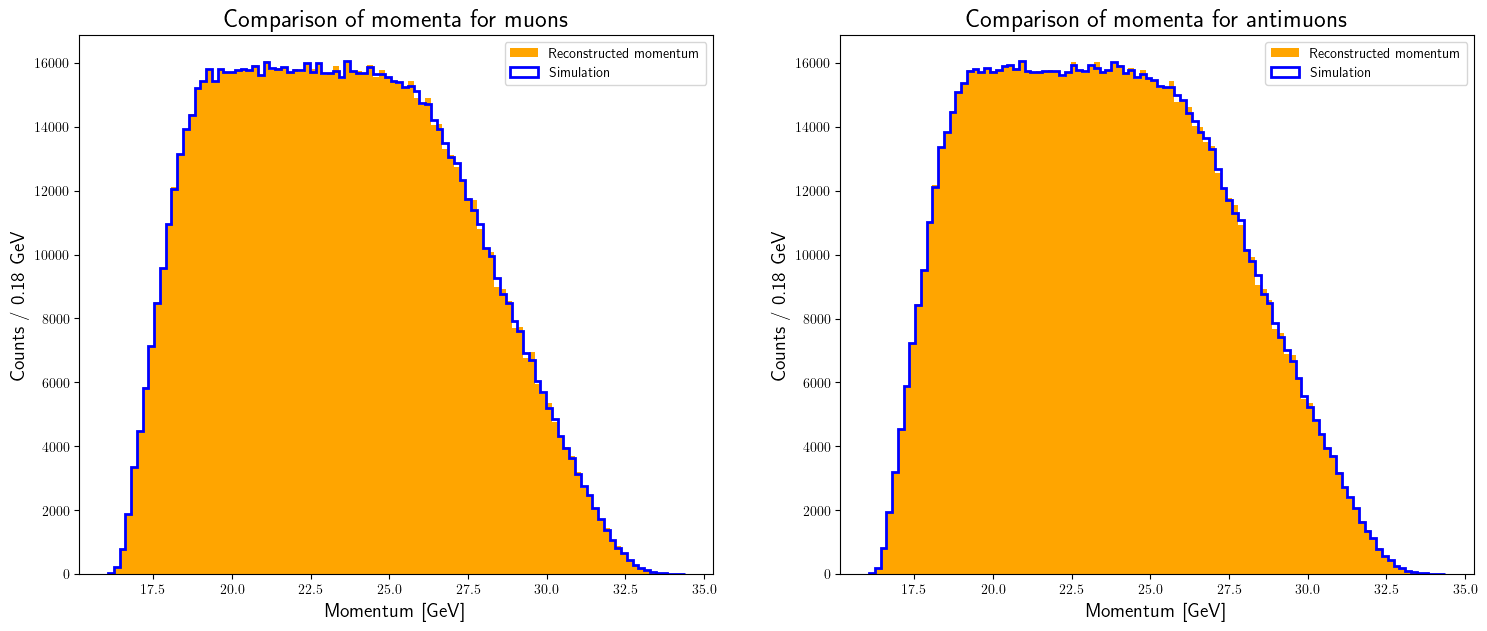

The reconstructed total muon momentum is comprised in the range [16.1, 34.38] GeV
The reconstructed total antimuon momentum is comprised in the range [16.06, 34.16] GeV 

The average muon momentum is 23.4747 GeV
The average antimuon momentum is 23.4672 GeV


In [43]:
# calculations for the total muon and antimuon momentum from the simulation
mu_Ptot_sim = (np.sqrt( (simulated_events["px_mu1"])**2 + (simulated_events["py_mu1"])**2 +(simulated_events["pz_mu1"])**2 )).values
antimu_Ptot_sim = (np.sqrt( (simulated_events["px_mu2"])**2 + (simulated_events["py_mu2"])**2 +(simulated_events["pz_mu2"])**2 )).values

# maximum and minimum momentum for the plots
pStart = np.min([np.min(mu_Ptot_sim), np.min(antimu_Ptot_sim), np.min(mu_reconstructed_P["P_tot"]), np.min(antimu_reconstructed_P["P_tot"])]) 
pStop = np.max([np.min(mu_Ptot_sim), np.max(antimu_Ptot_sim), np.max(mu_reconstructed_P["P_tot"]), np.max(antimu_reconstructed_P["P_tot"])])
nBins = 100

print("In the following the reconstructed momentum for muons and antimuons is compared with the simulation:")

plot_momentum(mu_reconstructed_P["P_tot"], antimu_reconstructed_P["P_tot"], mu_Ptot_sim, antimu_Ptot_sim, nBins, pStart, pStop)

print("The reconstructed total muon momentum is comprised in the range [{}, {}] GeV".format(
    round(np.min(mu_reconstructed_P["P_tot"]), 2), round(np.max(mu_reconstructed_P["P_tot"]), 2)))
print("The reconstructed total antimuon momentum is comprised in the range [{}, {}] GeV \n".format(
    round(np.min(antimu_reconstructed_P["P_tot"]), 2), round(np.max(antimu_reconstructed_P["P_tot"]), 2)))
print("The average muon momentum is {} GeV".format(round(np.mean(mu_reconstructed_P["P_tot"]), 4)))
print("The average antimuon momentum is {} GeV".format(round(np.mean(antimu_reconstructed_P["P_tot"]), 4)))

#### Residuals of the reconstructed momentum
In order to check the goodness of the reconstruction, the plot of the residuals between the reconstructed momentum and the simulated momentum are shown for each component. The plots are displayed after having removed the outliers whose difference with the mean value of the residuals distribution is more than $5\sigma$ (where $\sigma$ is the standard deviation of the residuals for the considered component).

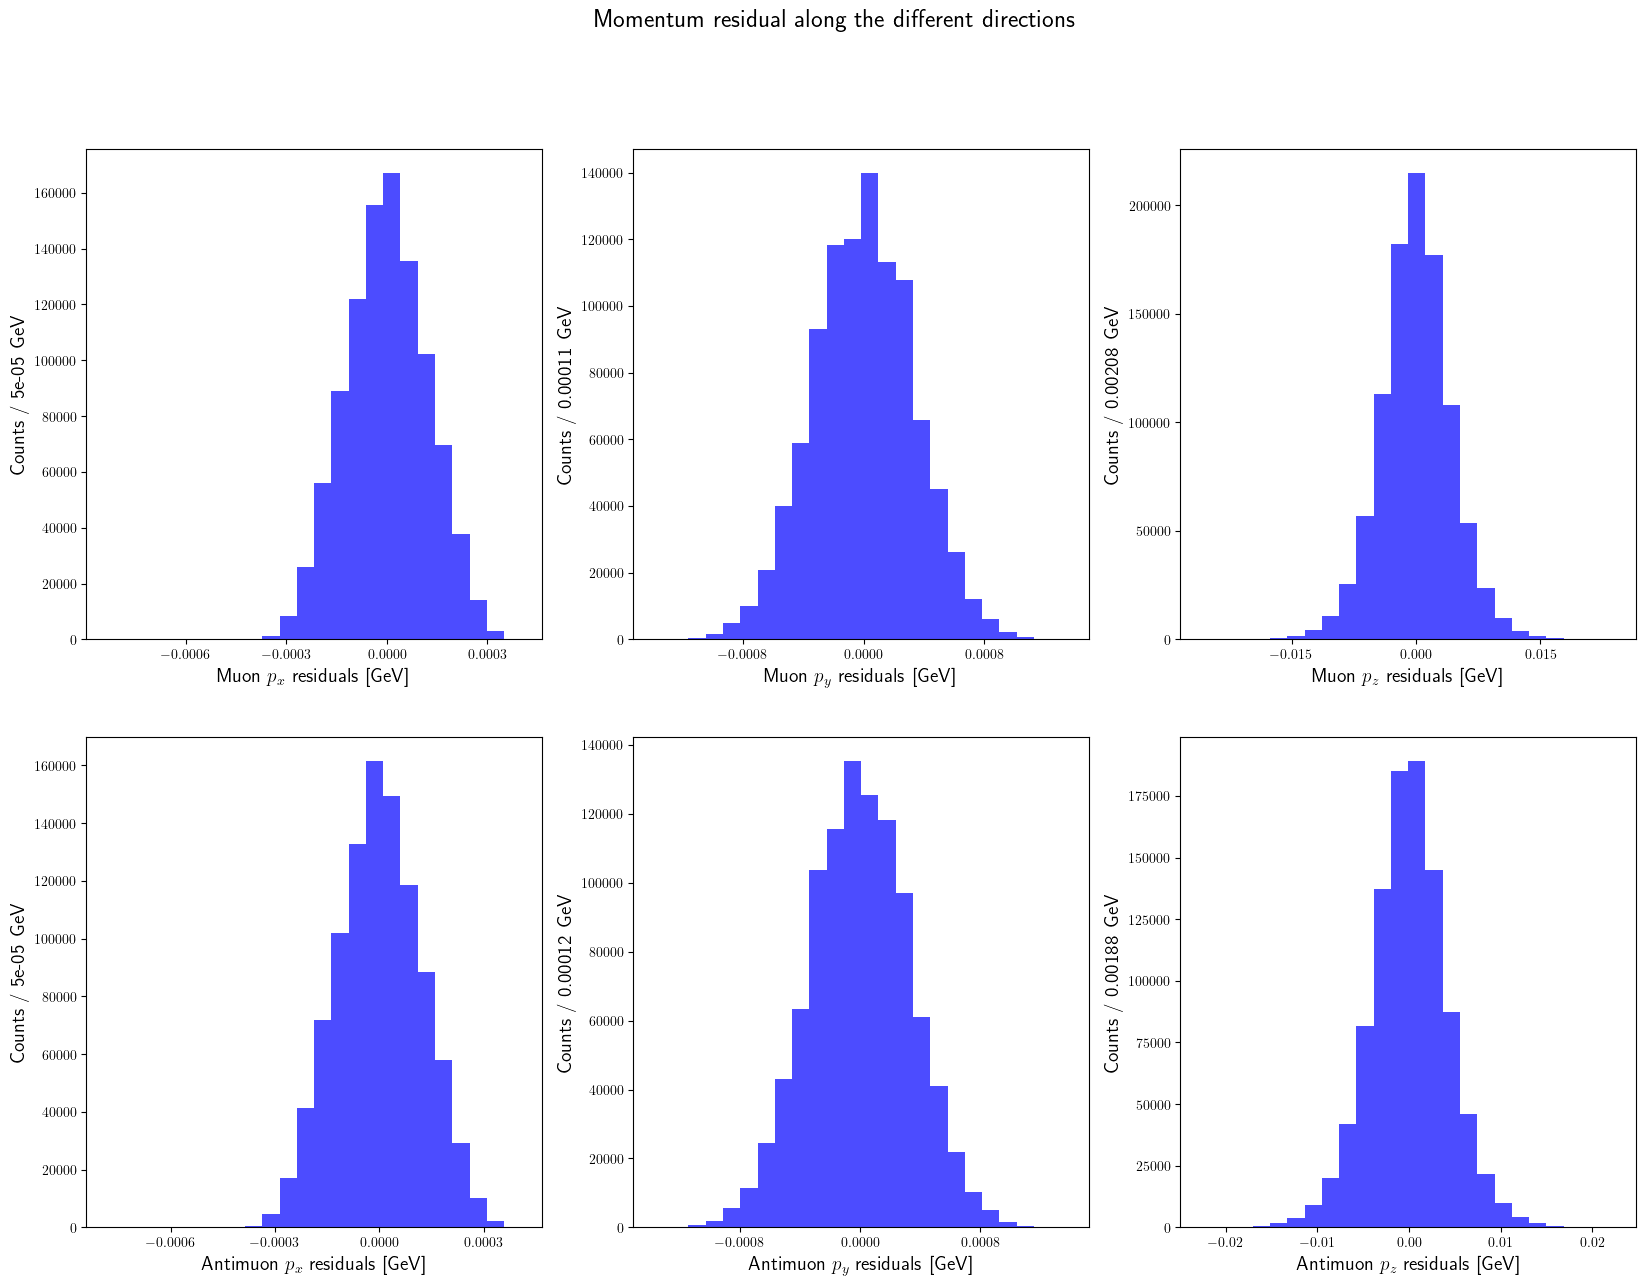

We expect 40 outliers from number of miss-identified pairs
Cutting at 5 sigma we get 41 outliers.


In [44]:
# after setting a number of sigma at which we decide to cut the outliers of the dataset, the residual for each momentum component is plotted.
n_sigma_out=5

# the mask containing the outliers is obtained
mask_outliers = plot_momentum_components_residuals(mu_reconstructed_P, antimu_reconstructed_P, simulated_events, nBins=24, n_sigma_out=n_sigma_out)
print("We expect",round((1-correctly_identified_fraction)*mu_reconstructed_P.shape[0]), "outliers from number of miss-identified pairs")
print("Cutting at {} sigma we get {} outliers.".format(n_sigma_out,np.sum(~mask_outliers)))

## Resolution of the momentum

The resolution of the muon and antimuon total reconstructed momentum is obtained as $\sigma_p/p$, where $p$ is the total momentum of the particle.
Before continuing the analysis the reconstructed events were cleaned by removing the outliers that were observed in the residuals plot.

### Helper functions

In [45]:
def plot_momentum_resolution_vs_momentum(res_mu, res_antimu, p_start, p_stop):
    # this function is used to plot the resolution of the momentum as a function of the momentum itself.
    # The extremes of the momentum range are passed as parameters
    
    fig, ax = plt.subplots(1, 2, figsize=(18,7))
    
    ax[0].scatter(res_mu["P_tot"], res_mu["P_tot_res"], color='blue', linestyle='dotted', lw=2)
    ax[1].scatter(res_antimu["P_tot"], res_antimu["P_tot_res"], color='blue', linestyle='dotted', lw=2)

    ax[0].set_xlim(p_start, p_stop)
    ax[1].set_xlim(p_start, p_stop)
#    ax[0].set_ylim(0, 0.0005)
#    ax[1].set_ylim(0, 0.0005)
    
    ax[0].set_title('Resolution of the momentum for muons', fontsize=16)
    ax[1].set_title('Resolution of the momentum for antimuons', fontsize=16)

    ax[0].set_xlabel(r"$p$ [GeV]", fontsize=16)
    ax[0].set_ylabel(r"$\sigma_p/p$", fontsize=16)
    ax[1].set_xlabel(r"$p$ [GeV]", fontsize=16)
    ax[1].set_ylabel(r"$\sigma_p/p$", fontsize=16)
    
    plt.show()
    
    return

def plot_different_momentum_resolution(resolution_mu, resolution_antimu, nBins):
    # this function is used to plot an histogram with the number of counts for the different resolution values.
    # The number of bins and the extremes of the range for the plot are passed as parameters.
    
    fig, ax = plt.subplots(1, 2, figsize=(18,7))
    
    ax[0].hist(resolution_mu["P_tot_res"], bins=nBins, alpha=0.7, color='blue')
    ax[1].hist(resolution_antimu["P_tot_res"], bins=nBins, alpha=0.7, color='blue')
    
    ax[0].set_title('Resolution of the momentum for muons', fontsize=18)
    ax[1].set_title('Resolution of the momentum for antimuons', fontsize=18)

    ax[0].set_xlabel(r"$\sigma_p/p$", fontsize=16)
    ax[0].set_ylabel(r"Counts", fontsize=16)
    ax[1].set_xlabel(r"$\sigma_p/p$", fontsize=16)
    ax[1].set_ylabel("Counts", fontsize=16)

#    ax[0].set_yscale("log")
#    ax[1].set_yscale("log")
    
    plt.show()
    
    return

### Code

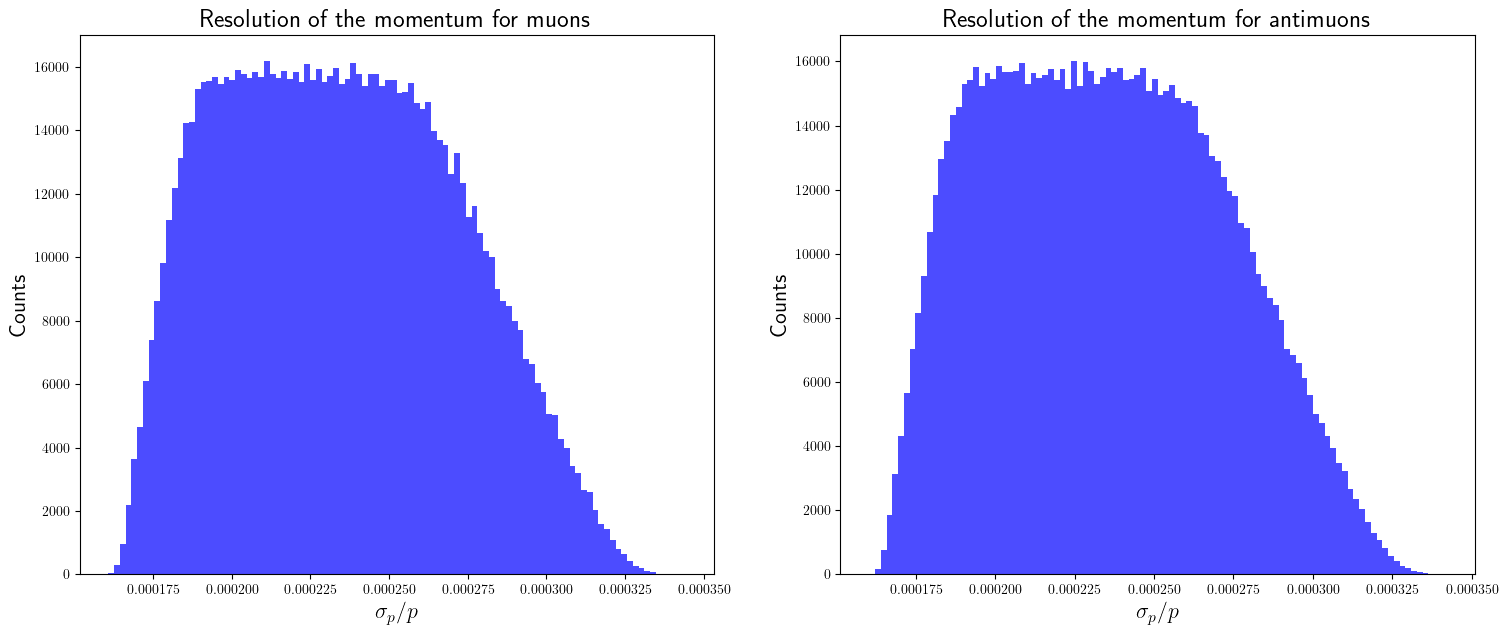

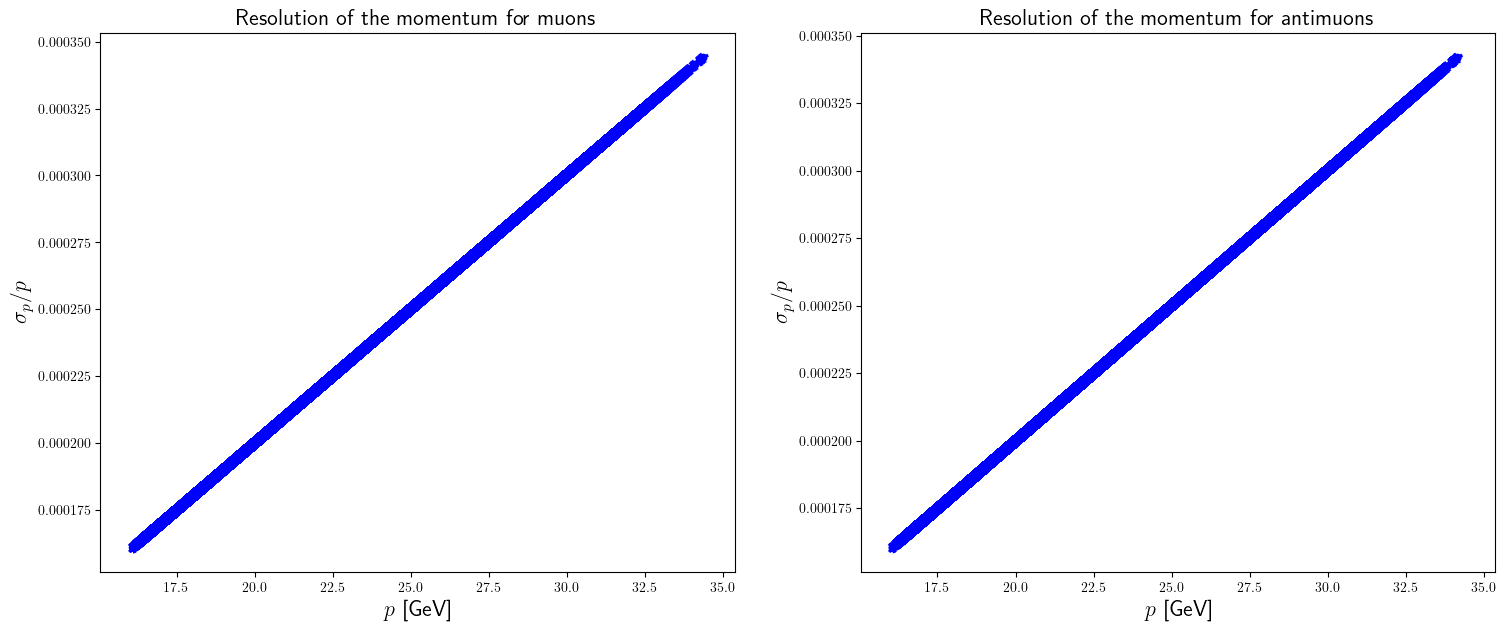

In [46]:
# two DataFrames containing the muon and antimuon total momentum resolution are created after having properly applied the
# "apparently_identified" mask
mu_resolution = pd.DataFrame({"P_tot": mu_reconstructed_P["P_tot"][mask_outliers], 
                              "P_tot_res": mu_reconstructed_P["P_tot_err"][mask_outliers]/mu_reconstructed_P["P_tot"][mask_outliers]})
antimu_resolution = pd.DataFrame({"P_tot": antimu_reconstructed_P["P_tot"][mask_outliers], 
                                  "P_tot_res": antimu_reconstructed_P["P_tot_err"][mask_outliers]/antimu_reconstructed_P["P_tot"][mask_outliers]})

# two other DataFrames containing the sorted events are created. They are used for the second plot
mu_res_sorted = mu_resolution.copy()
mu_res_sorted = mu_res_sorted.sort_values(by='P_tot')

antimu_res_sorted = antimu_resolution.copy()
antimu_res_sorted = antimu_res_sorted.sort_values(by='P_tot')

nBins = 100
plot_different_momentum_resolution(mu_resolution, antimu_resolution, nBins)
plot_momentum_resolution_vs_momentum(mu_res_sorted, antimu_res_sorted, pStart-1, pStop+1)

## Center of mass energy $\sqrt{s}$

Considering the four-momenta that characterises the muon and antimuon pairs,
$p_-=p_{\mu^-}=(E_-, \overrightarrow{p_-})$
and
$p_+=p_{\mu^+}=(E_+, \overrightarrow{p_+})$,
where the particle's energy is given by 
$$E_{\pm}=\sqrt{m_\mu^2+(\overrightarrow{p_\pm})^2},$$
in order to get the center of mass energy for the muon and antimuon pairs, the Mandelstam invariant $s$ is computed as:
$$ s = (p_++p_-)^2 = 2m_\mu^2+2(E_+E_--|\overrightarrow{p_+}||\overrightarrow{p_-}|\cos\alpha),$$
where $\alpha$ is the angle between the tri-momentum vectors.
<br>
The center of mass energy is given by $\sqrt{s}$.
<br>
The uncertainty on the center of mass energy is obtained by propagating the uncertainties on the momentum components for the muons and antimuons, after having expressed $s$ as function of these six variables. In this way the uncertainty is estimated in a straightforward way, without propagating multiple times the uncertainty on intermediate quantities that are used for the calculations.

### Helper functions

In [47]:
################################
# # GEOMETRIC HELPER FUNCTION  #
################################

def get_3D_cos_angle(mu_rec_p, antimu_rec_p):
    # this function compute the cosine of angle between the muon and antimuon tri-momenta.
    # It returns the cosine of the angle and its uncertainty, obtained usind the propagation of errors.
    num = mu_rec_p["P_x_ent"]*antimu_rec_p["P_x_ent"] + mu_rec_p["P_y"]*antimu_rec_p["P_y"] + mu_rec_p["P_z_ent"]*antimu_rec_p["P_z_ent"]
    cos_angle = num / (mu_rec_p["P_tot"]*antimu_rec_p["P_tot"])

    return cos_angle

In [48]:
############################
# # CENTER OF MASS ENERGY  #
############################

def get_CoM_energy(mu_rec_p, antimu_rec_p, mu_mass):
    # this function takes as parameters the reconstructed momentum for muons and antimuons and the muon mass expressed in GeV.
    # It returns the center of mass energy and its uncertainty estimated using the usual propagation of errors.
    
    cos_alpha = get_3D_cos_angle(mu_rec_p, antimu_rec_p)
    
    mu_energy = np.sqrt( mu_mass**2 + mu_rec_p["P_tot"]**2)
    antimu_energy = np.sqrt( mu_mass**2 + antimu_rec_p["P_tot"]**2)
    
    s = 2*mu_mass**2 + 2*(mu_energy*antimu_energy - mu_rec_p["P_tot"]*antimu_rec_p["P_tot"]*cos_alpha)
    
    s_error = np.sqrt( ( ( 2*mu_rec_p["P_x_ent"]*antimu_energy/mu_energy - 2*antimu_rec_p["P_x_ent"] )*mu_rec_p["P_x_ent_err"] )**2
                     + ( ( 2*mu_rec_p["P_y"]*antimu_energy/mu_energy - 2*antimu_rec_p["P_y"] )*mu_rec_p["P_y_err"] )**2
                     + ( ( 2*mu_rec_p["P_z_ent"]*antimu_energy/mu_energy - 2*antimu_rec_p["P_z_ent"] )*mu_rec_p["P_z_ent_err"] )**2
                     + ( ( 2*antimu_rec_p["P_x_ent"]*mu_energy/antimu_energy - 2*mu_rec_p["P_x_ent"] )*antimu_rec_p["P_x_ent_err"] )**2
                     + ( ( 2*antimu_rec_p["P_y"]*mu_energy/antimu_energy - 2*mu_rec_p["P_y"] )*antimu_rec_p["P_y_err"] )**2
                     + ( ( 2*antimu_rec_p["P_z_ent"]*mu_energy/antimu_energy - 2*mu_rec_p["P_z_ent"] )*antimu_rec_p["P_z_ent_err"] )**2)
    
    sqrt_s = np.sqrt(s)
    sqrt_s_error = s_error/(2*sqrt_s)
    
    CoM_energy = pd.DataFrame({"CoM_energy": sqrt_s, 
                               "CoM_energy_error": sqrt_s_error,
                               "CoM_energy_res": sqrt_s_error/sqrt_s})
    
    return CoM_energy

def get_sim_CoM_energy(sim_events, e_mass):
    # this function takes as input the DataFrame containing the simulated events and the electron mass in GeV.
    # It returns the calculated center of mass energy for the simulated positrons.
    
    p_squared_pos = sim_events["pz_positron"]**2 + sim_events["px_positron"]**2 + sim_events["py_positron"]**2
    s_pos = 2*e_mass**2 + 2*np.sqrt(e_mass**2+p_squared_pos)*e_mass
    CoM_energy_positrons = pd.DataFrame({"CoM_energy": np.sqrt(s_pos)})

    return CoM_energy_positrons

In [49]:
########################
# # PLOTTING FUNCTION  #
########################

def plot_CoM_energy(rec_CoM, sim_CoM, nBins, s_start, s_stop):
    # this function is used to plot an histogram with the number of counts for the different center of mass resolution values.
    # It takes as input a DataFrame containing the information about the center of mass energy and its resolution
    # the chosen number of bins and the extremes of the range in which the histogram is drawn.
    
    fig, ax = plt.subplots(1, 2, figsize=(18,7))
    bin_width = (s_stop-s_start)/nBins
    
    ax[0].hist(rec_CoM["CoM_energy"], bins=nBins, range=[s_start, s_stop], alpha=0.7, color='blue')
    ax[1].hist(sim_CoM.values, bins=nBins, range=[s_start, s_stop], alpha=0.7, color='blue')
    
    ax[0].set_title(r'Reconstructed $\sqrt{s}$ for muons-antimuons', fontsize=18)
    ax[0].set_xlabel(r"$\sqrt{s}$ [GeV]", fontsize=18)
    ax[0].set_ylabel("Counts / {} GeV".format(round(bin_width,4)), fontsize=18)
    
    ax[1].set_title(r'Simulated $\sqrt{s}$ for positrons', fontsize=18)
    ax[1].set_xlabel(r"$\sqrt{s}$ [GeV]", fontsize=18)
    ax[1].set_ylabel("Counts / {} GeV".format(round(bin_width,4)), fontsize=18)

#    ax.set_yscale("log")
    
    plt.show()
    
    return

### Code

In [50]:
mu_mass_GeV = muon_mass*c**2/(e*1e9) # --> muon mass in GeV

# a DataFrame containing the center of mass energy, its error and the estimated resolution is returned
sqrtS = get_CoM_energy(mu_reconstructed_P[mask_outliers], antimu_reconstructed_P[mask_outliers], mu_mass_GeV)
print("The reconstructed center of mass energy and its resolution:")
sqrtS

The reconstructed center of mass energy and its resolution:


,CoM_energy,CoM_energy_error,CoM_energy_res
0,0.220460,0.000152,0.000688
1,0.225061,0.000132,0.000587
2,0.220748,0.000564,0.002556
3,0.220307,0.000257,0.001167
4,0.221580,0.000138,0.000623
...,...,...,...
999909,0.216349,0.000250,0.001157
999910,0.216188,0.000453,0.002094
999911,0.212809,0.000181,0.000849
999912,0.221516,0.000480,0.002167


In order to compare the reconstructed center of mass energy with the simulation, the center of mass energy for the positron-electron pairs is estimated.
<br>
Considering the target electrons at rest, with four momentum
$p_{e^-}=(m_e,\overrightarrow{0})$, 
and the positrons with four momentum
$p_{e^+}=(E_{e^+},\overrightarrow{p_{e^+}})$,
the center of mass energy squared is given by:
$$ s=2m_e^2+2m_e\sqrt{m_e^2+|\overrightarrow{p_{e^+}}|^2}.$$

In [51]:
e_mass_GeV = electron_mass*c**2/(e*1e9) # --> positron mass in GeV

# the center of mass energy is also calculated for the simulated positrons in order to compare the results
# with the reconstructed center of mass energy 
simulated_CoM_energy_pos = get_sim_CoM_energy(simulated_events[mask_outliers], e_mass_GeV)

print("Calculated center of mass energy from the simulated positrons:")
simulated_CoM_energy_pos

Calculated center of mass energy from the simulated positrons:


,CoM_energy
0,0.220550
1,0.225225
2,0.220641
3,0.220402
4,0.221699
...,...
999909,0.216332
999910,0.216105
999911,0.212915
999912,0.221578


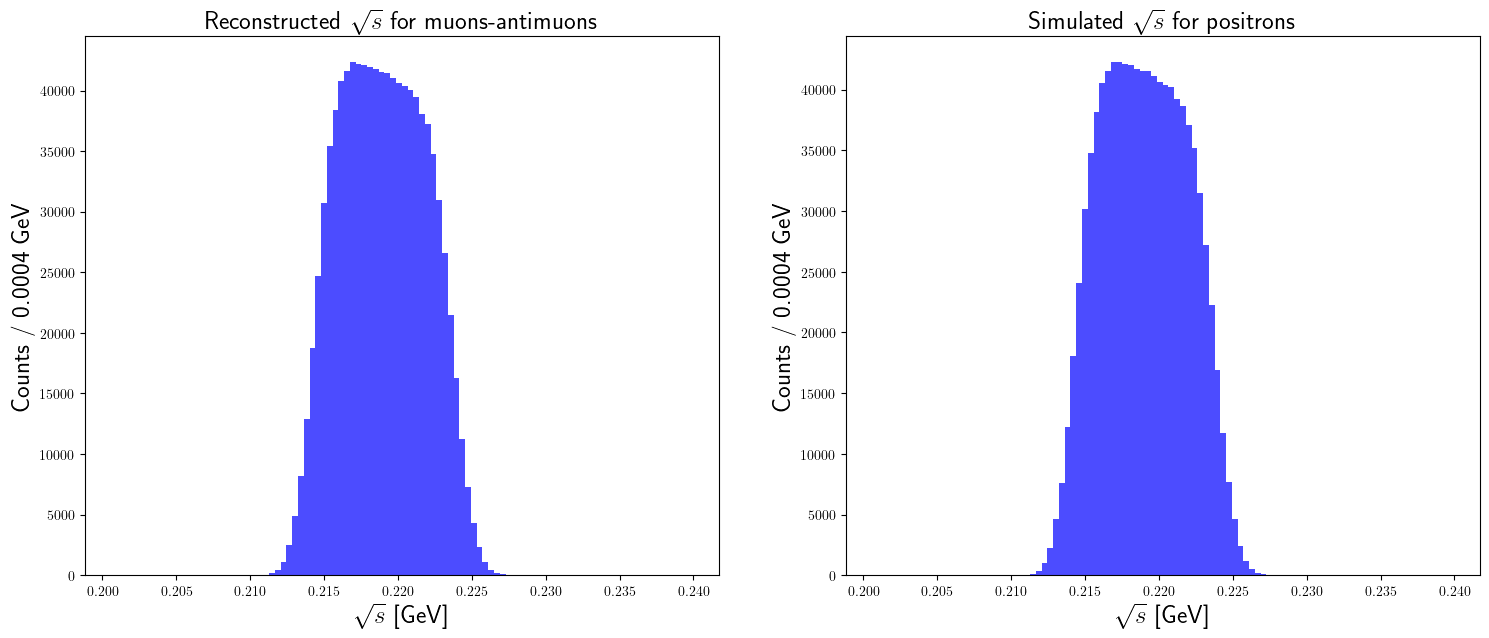

The reconstructed center of mass energy for the muon-antimuon pairs is comprised in the range [0.2113, 0.2283] GeV
The total center of mass energy for the simulated positron-electron pairs is comprised in the range [0.2114, 0.2284] GeV 

The average center of mass energy for the muon-antimuon pairs is 0.219 GeV
The average center of mass energy for the positron-electron pairs is 0.219 GeV


In [52]:
# The extremes of the range in which the histogram is plotted are chosen according to the spread of the data
s_start = np.min(sqrtS["CoM_energy"])*0.95
s_stop = np.max(sqrtS["CoM_energy"])*1.05
nBins = 100

plot_CoM_energy(sqrtS, simulated_CoM_energy_pos, nBins, s_start, s_stop)

print("The reconstructed center of mass energy for the muon-antimuon pairs is comprised in the range [{}, {}] GeV".format(
    round(np.min(sqrtS["CoM_energy"]), 4), round(np.max(sqrtS["CoM_energy"]), 4)))
print("The total center of mass energy for the simulated positron-electron pairs is comprised in the range [{}, {}] GeV \n".format(
    round(np.min(simulated_CoM_energy_pos["CoM_energy"]), 4), round(np.max(simulated_CoM_energy_pos["CoM_energy"]), 4)))
print("The average center of mass energy for the muon-antimuon pairs is {} GeV".format(round(np.mean(sqrtS["CoM_energy"]), 4)))
print("The average center of mass energy for the positron-electron pairs is {} GeV".format(round(np.mean(simulated_CoM_energy_pos["CoM_energy"]), 4)))

## Resolution of the center of mass energy

The resolution of the muon-antimuon pair reconstructed center of mass energy is obtained as $\sigma_\sqrt{s}/\sqrt{s}$, where $\sqrt{s}$ is the center of mass energy of the muon-antimuon pair.

### Helper functions

In [53]:
def plot_s_resolution_vs_s(res_CoM, p_start, p_stop):
    # this function is used to plot the resolution of the center of mass energy as a function of the center of mass energy itself
    
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    
    ax.scatter(res_CoM["CoM_energy"], res_CoM["CoM_energy_res"], color='blue')
    ax.set_xlim(p_start, p_stop)
    
    ax.set_title(r'Resolution of $\sqrt{s}$ for muons', fontsize=18)
    ax.set_xlabel(r"$\sqrt{s}$ [GeV]", fontsize=14)
    ax.set_ylabel(r"$\sigma_{\sqrt{s}} / \sqrt{s}$", fontsize=18)
    
    plt.show()
    
    return

def plot_different_s_resolution(res_CoM, nBinse):
    # this function is used to plot an histogram with the number of counts for the different resolution values
    
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    
    ax.hist(res_CoM["CoM_energy_res"], bins=nBins, alpha=0.7, color='blue')
    
    ax.set_title(r'Resolution of the $\sqrt{s}$', fontsize=18)
    ax.set_xlabel(r"$\sigma_{\sqrt{s}}/\sqrt{s}$", fontsize=18)
    ax.set_ylabel("Counts", fontsize=18)

#    ax.set_yscale("log")
    
    plt.show()
    
    return

### Code

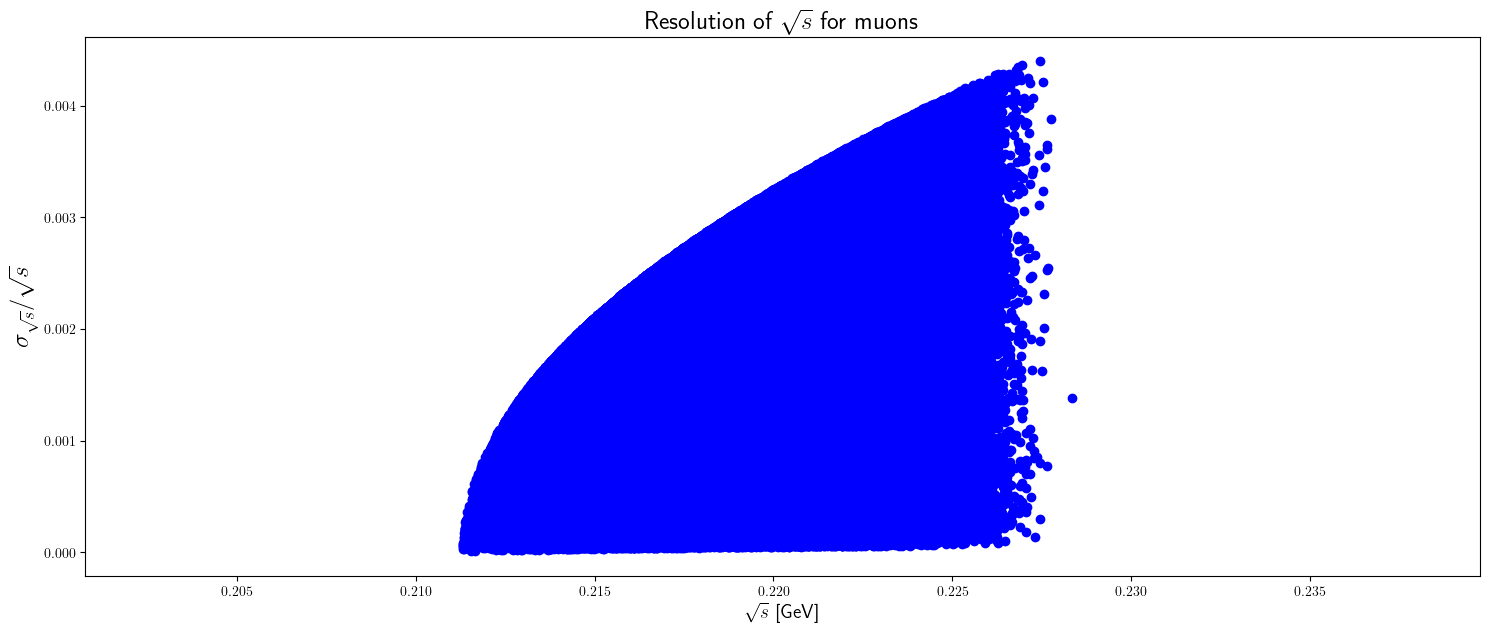

In [54]:
# the center of mass energy DataFrame is sorted according to the center of mass energy
CoM_energy_sorted = sqrtS.copy()
CoM_energy_sorted = CoM_energy_sorted.sort_values(by='CoM_energy')
nan_indices = CoM_energy_sorted['CoM_energy_error'].isna()
CoM_energy_sorted = CoM_energy_sorted.dropna()
CoM_energy_sorted = CoM_energy_sorted.sort_values(by='CoM_energy_res')

plot_s_resolution_vs_s(CoM_energy_sorted, s_start, s_stop)

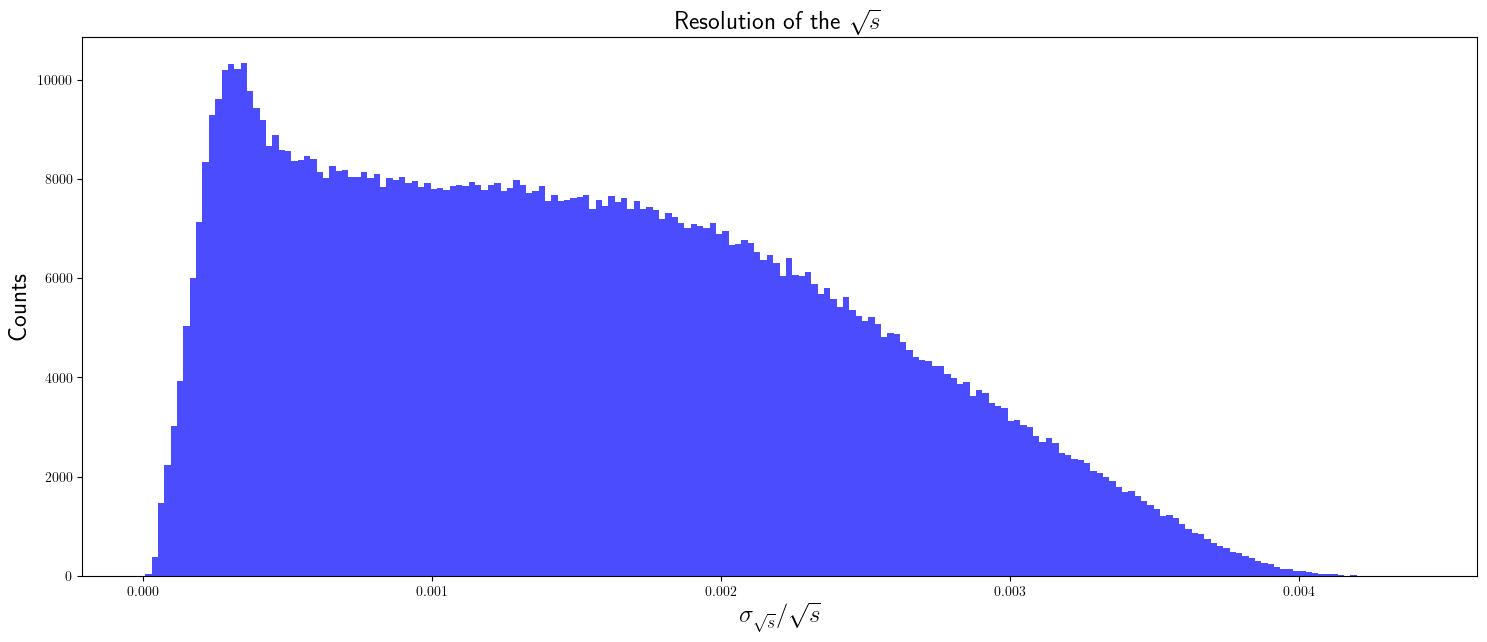

In [55]:
nBins = 200
plot_different_s_resolution(sqrtS, nBins)

## Conclusions

In summary, the results obtained with this configuration and type of analysis appear to be good. In particular, the fact that 99.996% of the identified traces are classified correctly is an excellent outcome. However, this analysis can be refined. Firstly, it does not consider the interactions of muons with the detectors, which can potentially deviate the traces, complicating the analysis. Secondly, there has been little consideration for the error in the positioning of the detectors along the path of the particles. In a real experiment, an alignment procedure would need to be conducted before the analysis. In the setup presented here, perfect alignment is assumed (each pixel is exactly where it should be), which would not be feasible in practice.